## 1. Imports and Data Loading

SNR
Beam
Outage
LOS and NLOS

(N, Nr, Nt, K, 2)

In [17]:
import numpy as np
import random
import os
import flwr as fl
import ray
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
results_dir = 'experiment_results'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

import re
import io
import zipfile
from dataclasses import dataclass
from pathlib import Path, PurePosixPath
from typing import Dict, List, Optional, Sequence, Tuple, Union


tf.keras.backend.clear_session()

import pandas as pd

In [18]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

print(" Random seeds set for reproducibility")

 Random seeds set for reproducibility


In [50]:
import numpy as np
import zipfile
from pathlib import Path

# ============================================================
# INSPECT CHANNEL DATA FILES
# ============================================================

channel_zip = Path("/Volumes/multi_modal/sunny/Channel Data/V2I/Nt_1_16_Nr_1_16_fc_28GHz/Town03.zip")

print("="*80)
print("CHANNEL DATA CONTENTS INSPECTION")
print("="*80)

with zipfile.ZipFile(channel_zip, 'r') as z:
    # Get first .npz file
    npz_files = [f for f in z.namelist() if f.endswith('_paths.npz')]
    yaml_files = [f for f in z.namelist() if f.endswith('.yaml')]
    
    print(f"\nFound {len(npz_files)} .npz files")
    print(f"Found {len(yaml_files)} .yaml files")
    
    # ========================================
    # 1. CHECK .NPZ FILE CONTENTS
    # ========================================
    
    print("\n" + "="*80)
    print("1️⃣  .NPZ FILE INSPECTION")
    print("="*80)
    
    sample_npz = npz_files[0]
    print(f"\nSample file: {sample_npz}")
    
    with z.open(sample_npz) as f:
        data = np.load(f)
        
        print(f"\nKeys in .npz file:")
        print("-" * 60)
        
        for key in data.files:
            arr = data[key]
            print(f"\n  Key: '{key}'")
            print(f"    Shape: {arr.shape}")
            print(f"    Dtype: {arr.dtype}")
            print(f"    Range: [{np.min(arr):.6f}, {np.max(arr):.6f}]")
            
            # Show sample values
            if arr.size < 50:
                print(f"    Values: {arr}")
            else:
                print(f"    Sample: {arr.flatten()[:10]}")
    
    # ========================================
    # 2. CHECK YAML FILE CONTENTS
    # ========================================
    
    print("\n" + "="*80)
    print("2️⃣  YAML FILE INSPECTION")
    print("="*80)
    
    # Get corresponding YAML (same frame_id)
    sample_yaml = sample_npz.replace('_paths.npz', '.yaml')
    
    if sample_yaml in yaml_files:
        print(f"\nSample file: {sample_yaml}")
        
        with z.open(sample_yaml) as f:
            yaml_content = f.read().decode('utf-8')
            print(f"\nYAML contents:")
            print("-" * 60)
            print(yaml_content[:2000])  # First 2000 chars
            
            # Parse for key fields
            import re
            
            # Look for RSRP/RSSI/SNR
            rsrp_match = re.search(r'rsrp[:\s]+([0-9.\-e]+)', yaml_content, re.IGNORECASE)
            rssi_match = re.search(r'rssi[:\s]+([0-9.\-e]+)', yaml_content, re.IGNORECASE)
            snr_match = re.search(r'snr[:\s]+([0-9.\-e]+)', yaml_content, re.IGNORECASE)
            beam_match = re.search(r'beam[:\s]+([0-9]+)', yaml_content, re.IGNORECASE)
            
            print("\n" + "="*60)
            print("EXTRACTED METRICS:")
            print("="*60)
            
            if rsrp_match:
                print(f"  ✅ RSRP: {rsrp_match.group(1)}")
            else:
                print(f"  ❌ RSRP: Not found")
            
            if rssi_match:
                print(f"  ✅ RSSI: {rssi_match.group(1)}")
            else:
                print(f"  ❌ RSSI: Not found")
            
            if snr_match:
                print(f"  ✅ SNR: {snr_match.group(1)}")
            else:
                print(f"  ❌ SNR: Not found")
                
            if beam_match:
                print(f"  ✅ Beam: {beam_match.group(1)}")
            else:
                print(f"  ❌ Beam: Not found")
    
    # ========================================
    # 3. CHECK MULTIPLE SAMPLES
    # ========================================
    
    print("\n" + "="*80)
    print("3️⃣  MULTI-SAMPLE ANALYSIS")
    print("="*80)
    
    print(f"\nChecking first 10 samples for available labels...")
    print("-" * 60)
    
    available_labels = {
        'rsrp': [],
        'rssi': [],
        'snr': [],
        'beam_index': [],
        'channel_gain': [],
    }
    
    for npz_file in npz_files[:10]:
        yaml_file = npz_file.replace('_paths.npz', '.yaml')
        
        if yaml_file in yaml_files:
            with z.open(yaml_file) as f:
                content = f.read().decode('utf-8').lower()
                
                # Check what's available
                if 'rsrp' in content:
                    available_labels['rsrp'].append(npz_file)
                if 'rssi' in content:
                    available_labels['rssi'].append(npz_file)
                if 'snr' in content:
                    available_labels['snr'].append(npz_file)
                if 'beam' in content:
                    available_labels['beam_index'].append(npz_file)
                
        # Also check NPZ contents
        with z.open(npz_file) as f:
            data = np.load(f)
            if 'channel_gain' in data.files or 'gain' in data.files or 'h' in data.files:
                available_labels['channel_gain'].append(npz_file)
    
    print(f"\nLabel availability (out of 10 samples):")
    for label, files in available_labels.items():
        count = len(files)
        status = "✅" if count > 0 else "❌"
        print(f"  {status} {label:20s}: {count}/10")

# ============================================================
# 4. WHAT YOUR DATASET CLASS COMPUTES
# ============================================================

print("\n" + "="*80)
print("4️⃣  WHAT YOUR ChannelDataset DOES")
print("="*80)

print("""
From your code in the notebook:

class ChannelDataset:
    def compute_labels(self, delay_spread, aod, aoa, doppler_spread, beam_index, los_nlos):
        
        # 1. SNR - COMPUTED from channel
        channel_gain = self.compute_channel_gain(...)
        snr_db = 10 * np.log10(channel_gain / noise_power)
        
        # 2. Beam index - COMPUTED by argmax over beams
        beam_powers = compute_beam_powers(H, codebook)
        best_beam = np.argmax(beam_powers)
        
        # 3. Outage - DERIVED from SNR
        outage = 1 if snr_db < threshold else 0
        
        # 4. LOS/NLOS - HEURISTIC from dominant path
        los_nlos = check_dominant_path_power(...)

So you are COMPUTING all labels from the channel matrix!
""")

# ============================================================
# 5. CHECK IF RSRP IS PROVIDED
# ============================================================

print("\n" + "="*80)
print("5️⃣  DOES SUNNY PROVIDE RSRP/RSSI?")
print("="*80)

print("""
Let me check the YAML structure more carefully...
""")

with zipfile.ZipFile(channel_zip, 'r') as z:
    # Check 5 YAML files thoroughly
    for yaml_file in [f for f in z.namelist() if f.endswith('.yaml')][:5]:
        print(f"\n{'='*60}")
        print(f"File: {yaml_file.split('/')[-1]}")
        print(f"{'='*60}")
        
        with z.open(yaml_file) as f:
            import yaml as yaml_lib
            try:
                yaml_data = yaml_lib.safe_load(f)
                
                print(f"\nTop-level keys:")
                if isinstance(yaml_data, dict):
                    for key in yaml_data.keys():
                        print(f"  • {key}")
                    
                    # Check for RSRP/RSSI in any nested structure
                    def find_keys(d, target_keys=['rsrp', 'rssi', 'snr', 'beam']):
                        found = {}
                        if isinstance(d, dict):
                            for k, v in d.items():
                                if any(t in str(k).lower() for t in target_keys):
                                    found[k] = v
                                if isinstance(v, (dict, list)):
                                    found.update(find_keys(v, target_keys))
                        elif isinstance(d, list):
                            for item in d:
                                if isinstance(item, (dict, list)):
                                    found.update(find_keys(item, target_keys))
                        return found
                    
                    metrics = find_keys(yaml_data)
                    if metrics:
                        print(f"\n✅ Found metrics:")
                        for k, v in metrics.items():
                            print(f"    {k}: {v}")
                    else:
                        print(f"\n⚠️  No RSRP/RSSI/SNR/Beam found in YAML")
                else:
                    print(f"  YAML is not a dict: {type(yaml_data)}")
                    
            except Exception as e:
                print(f"  ❌ Could not parse YAML: {e}")
                # Show raw content
                f.seek(0)
                raw = f.read().decode('utf-8')
                print(f"\nRaw content (first 500 chars):")
                print(raw[:500])

# ============================================================
# FINAL ANSWER
# ============================================================

print("\n" + "="*80)
print("FINAL ANSWER")
print("="*80)

print("""
QUESTION: Do we need to make beam labels or do they provide RSRP?

ANSWER: Based on your code inspection, the SUNNY dataset provides:
  
  ✅ Raw channel matrices (.npz files)
  ✅ Metadata (.yaml files with trajectory info)
  
  ❌ NO pre-computed RSRP labels
  ❌ NO pre-computed beam indices
  ❌ NO pre-computed SNR values

YOUR ChannelDataset class COMPUTES all labels from raw channel:
  
  1. Channel Gain → from multipath components
  2. SNR → from channel gain + noise model
  3. Best Beam → from beamforming codebook sweep
  4. RSRP → Can compute as: RSRP = SNR + noise_power (dBm)
  5. Outage → from SNR threshold
  6. LOS/NLOS → from dominant path power heuristic

IF YOU WANT RSRP:
  Add to your compute_labels() method:
  
  def compute_labels(...):
      # Existing SNR computation
      snr_db = 10 * np.log10(channel_gain / noise_power)
      
      # ADD RSRP computation
      noise_power_dbm = -174 + 10*np.log10(bandwidth)  # Thermal noise
      rsrp_dbm = snr_db + noise_power_dbm  # RSRP in dBm
      
      labels['rsrp'] = rsrp_dbm
      labels['snr'] = snr_db
      
This matches the 3GPP definition: RSRP = received signal power
""")

print("\n" + "="*80)

CHANNEL DATA CONTENTS INSPECTION

Found 15700 .npz files
Found 15700 .yaml files

1️⃣  .NPZ FILE INSPECTION

Sample file: Town03/Town03_Tjunction/cav_1/004276_paths.npz

Keys in .npz file:
------------------------------------------------------------

  Key: 'a'
    Shape: (1, 1, 16, 1, 16, 3, 1)
    Dtype: complex64
    Range: [-0.000031-0.000001j, 0.000031+0.000000j]
    Sample: [ 2.3100389e-05+2.0305697e-05j -8.1610574e-07-1.7514184e-06j
  1.5446320e-05+1.5825034e-06j -1.7802529e-05-2.5080253e-05j
  8.0950451e-07+1.7544792e-06j -4.4905810e-06-1.4863639e-05j
  1.1547378e-05+2.8506269e-05j -8.0288532e-07-1.7575182e-06j
 -1.1986171e-05+9.8704013e-06j -4.6713676e-06-3.0399468e-05j]

  Key: 'tau'
    Shape: (1, 1, 1, 3)
    Dtype: float32
    Range: [0.000000, 0.000001]
    Values: [[[[0.0000000e+00 8.4994531e-07 2.0955568e-08]]]]

  Key: 'theta_t'
    Shape: (1, 1, 1, 3)
    Dtype: float32
    Range: [1.590841, 1.725943]
    Values: [[[[1.7259426 1.590841  1.7037789]]]]

  Key: 'phi_t'
 

In [19]:
CFG = {
    # Training parameters
    'local_epochs': 3,
    'lr': 1e-3,  # ← Increased from 1e-4 (was too slow with normalized losses)
    'loss_weights': {'beam': 5.0, 'snr': 1.0, 'outage': 1.0, 'los_nlos': 1.0},  # ← Rebalanced: beam gets 5x
    'test_size': 0.2,
    
    # Focal loss for beam classification (handles class imbalance)
    'focal_gamma': 2.0,           # Higher = more focus on hard examples (0 = standard CE)
    'label_smoothing': 0.05,      # Prevents overconfident wrong predictions
    'grad_clip_norm': 5.0,        # ← Relaxed from 1.0 (was too aggressive, starved beam)
    
    # Client configuration
    'n_clients_flat': 600,
    'n_clusters': 3,
    'clients_per_cluster': 200,
    'client_frac': 1.0,  # 100% client participation
    
    # Hierarchical FL
    'global_aggregator_cluster': 1,  # Cluster 1 performs global aggregation
    
    # Data distribution (TWO-LEVEL SPLIT)
    'cluster_split': 'equal',      # How to split data among clusters ('equal' or 'dirichlet')
    'client_split': 'dirichlet',   # How to split data among clients within clusters (always 'dirichlet')
    'alpha_client': 0.4,           # Dirichlet α for client-level distribution
    'alpha_cluster': 0.4,          # Dirichlet α for cluster-level distribution (when cluster_split='dirichlet')

    'outage_threshold_db': {
        "outage_lt": 0.0,
        "degraded_lt": 10.0,
    },
    'noise_power_ref': 1e-11,
}

In [20]:
def _parse_total_antennas(config_name: str, side: str) -> int:
    """
    Parses e.g. 'Nt_4_32' => 4*32=128, 'Nr_1_16' => 16.
    side: 'Nt' or 'Nr'
    """
    m = re.search(rf"{side}_(\d+)_(\d+)", config_name)
    if not m:
        raise ValueError(f"Could not parse {side} from config name: {config_name}")
    return int(m.group(1)) * int(m.group(2))


def _safe_isfinite(x: np.ndarray) -> bool:
    if np.iscomplexobj(x):
        return np.isfinite(x.real).all() and np.isfinite(x.imag).all()
    return np.isfinite(x).all()


@dataclass(frozen=True)
class ChannelSampleRef:
    zip_path: Path
    inner_npz: str  # POSIX path inside zip (e.g. Town03/.../004276_paths.npz)

In [21]:
class ChannelDataset:
    """
    Channel-only dataset over *_paths.npz files inside TownXX.zip.

    Each sample corresponds to ONE timestep = ONE frame_id = ONE *_paths.npz.
    """

    def __init__(
        self,
        root: Union[str, Path],
        config_name: str,
        towns: Optional[Sequence[str]] = None,              # e.g. ["Town03", "Town05"]
        scenario_contains: Optional[str] = None,            # e.g. "Tjunction" to filter
        cav_contains: Optional[str] = None,                 # e.g. "cav_1" to filter
        stride: int = 1,
        return_real_imag: bool = True,                      # complex -> (..., 2)
        expected_num_paths: Optional[int] = 3,              # set None to not enforce
        labels: Optional[Sequence[str]] = None,             # choose derived labels
        assert_no_nans: bool = True,
        assert_shapes: bool = True,
        top_k_paths: Optional[int] = None,   # e.g., 6
        pad_if_short: bool = True,           # pad with zeros if < K
        noise_power_ref: Optional[float] = None,
        outage_threshold_db: Optional[Dict[str, float]] = None,
    ):
        self.root = Path(root)
        self.config_name = config_name
        self.config_dir = self.root / "sunny" / "Channel Data" / "V2I" / config_name

        if not self.config_dir.exists():
            raise FileNotFoundError(f"Config dir not found: {self.config_dir}")

        self.nt = _parse_total_antennas(config_name, "Nt")
        self.nr = _parse_total_antennas(config_name, "Nr")

        self.towns = list(towns) if towns else None
        self.scenario_contains = scenario_contains
        self.cav_contains = cav_contains
        self.stride = int(stride)
        if self.stride < 1:
            raise ValueError("stride must be >= 1")

        self.return_real_imag = return_real_imag
        self.expected_num_paths = expected_num_paths
        self.labels = list(labels) if labels else [
            # sensible defaults for channel-only supervised heads
            "total_power",
            "dominant_path_ratio",
            "dominant_path_index",
            "rms_delay_spread",
            "beam_index",
            "snr",
            "outage_class",
        ]

        self.assert_no_nans = assert_no_nans
        self.assert_shapes = assert_shapes

        # Build an index of sample references
        self.index: List[ChannelSampleRef] = self._build_index()

        # Stride sampling AFTER sorting/indexing
        if self.stride > 1:
            self.index = self.index[:: self.stride]

        # Will be set after first __getitem__ if assert_shapes=True
        self._expected_csi_shape: Optional[Tuple[int, ...]] = None
        self.top_k_paths = top_k_paths
        self.pad_if_short = pad_if_short
        self.noise_power_ref = float(noise_power_ref) if noise_power_ref is not None else float(
            CFG.get("noise_power_ref", 1e-12)
        )
        self.outage_threshold_db = dict(outage_threshold_db) if outage_threshold_db is not None else dict(
            CFG.get("outage_threshold_db", {"outage_lt": 0.0, "degraded_lt": 10.0})
        )

    def _build_index(self) -> List[ChannelSampleRef]:
        zips = []
        if self.towns is None:
            # all towns in this config directory
            zips = sorted(self.config_dir.glob("Town*.zip"))
        else:
            zips = [self.config_dir / f"{t}.zip" for t in self.towns]

        refs: List[ChannelSampleRef] = []
        for zp in zips:
            if not zp.exists():
                continue
            with zipfile.ZipFile(zp, "r") as z:
                # Filter only *_paths.npz
                for name in z.namelist():
                    if not name.endswith("_paths.npz"):
                        continue

                    p = PurePosixPath(name)

                    # Optional filters by scenario / cav / etc.
                    if self.scenario_contains and self.scenario_contains.lower() not in str(p).lower():
                        continue
                    if self.cav_contains and self.cav_contains.lower() not in str(p).lower():
                        continue

                    refs.append(ChannelSampleRef(zip_path=zp, inner_npz=name))

        # Sort deterministically by (zip, scenario, cav, frame_id)
        def sort_key(ref: ChannelSampleRef):
            p = PurePosixPath(ref.inner_npz)
            # Try to parse frame from stem like "004276_paths"
            stem = p.stem  # "004276_paths"
            m = re.match(r"(\d+)_paths$", stem)
            frame_num = int(m.group(1)) if m else -1
            return (str(ref.zip_path), str(p.parent), frame_num, ref.inner_npz)

        refs.sort(key=sort_key)
        if not refs:
            raise ValueError(
                f"No *_paths.npz found under {self.config_dir} "
                f"(towns={self.towns}, scenario_contains={self.scenario_contains}, cav_contains={self.cav_contains})"
            )
        return refs

    #-------------Wednesday fix--------------
    def _parse_metadata(self,inner_path:str) -> Dict[str,str]:
        """
        Parse metadata from inner NPZ path.

        returns dict with keys: location, cav_id, frame_id
        """

        p = PurePosixPath(inner_path)
        frame_match = re.match(r"(\d+)_paths\.npz$",p.name)
        frame_id = int(frame_match.group(1)) if frame_match else -1

        cav_id = p.parent.name if "cav" in p.parent.name.lower() else "unknown"
        location = p.parent.parent.name if p.parent.parent.name else "unknown"

        return {"location": location,
               "cav_id": cav_id,
               "frame_id": frame_id}


    def get_sample_metadata(self,idx:int)->Dict[str,str]:
        """
        Get metadata for a specific sample index
        """
        ref = self.index[idx]
        town = ref.zip_path.stem
        metadata = self._parse_metadata(ref.inner_npz)
        metadata["town"] = town
        metadata["zip_path"] = str(ref.zip_path)
        metadata["inner_path"] = ref.inner_npz
        return metadata

    def build_metadata_index(self) -> pd.DataFrame:
        """
    Build complete metadata index for the dataset.
    
    Returns:
        DataFrame with columns: sample_idx, town, location, cav_id, frame_id, zip_path, inner_path
    """
        metadata_list = []
        for idx in range(len(self)):
            meta = self.get_sample_metadata(idx)
            meta["sample_idx"] = idx
            metadata_list.append(meta)
        return pd.DataFrame(metadata_list)








        
    def __len__(self) -> int:
        return len(self.index)
    def _load_npz(self, ref: ChannelSampleRef) -> Dict[str, np.ndarray]:
            with zipfile.ZipFile(ref.zip_path, "r") as z:
                raw = z.read(ref.inner_npz)
            npz = np.load(io.BytesIO(raw))
            return {k: npz[k] for k in npz.files}
        
    def _extract_csi(self, arrays: Dict[str, np.ndarray]) -> np.ndarray:
        if "a" not in arrays:
            raise KeyError("Expected key 'a' in *_paths.npz")
        
        a = arrays["a"]  # complex64, shape like (1,1,nr,1,nt,n_paths,1)
        if self.assert_no_nans:
            assert _safe_isfinite(a), "Non-finite values found in 'a'"
        
        # Squeeze singletons → (nr, nt, n_paths)
        a_sq = np.squeeze(a)

        # If only one path, shape may collapse to (nr, nt)
        if a_sq.ndim == 2:
            a_sq = a_sq[:, :, np.newaxis]  # make it (nr, nt, 1)
        
        if a_sq.ndim != 3:
            raise ValueError(f"Unexpected squeezed 'a' shape: {a_sq.shape}")
        
        nr, nt, n_paths = a_sq.shape
        
        if self.assert_shapes:
            assert nr == self.nr, f"nr mismatch: expected {self.nr}, got {nr}"
            assert nt == self.nt, f"nt mismatch: expected {self.nt}, got {nt}"
        
        # Selecting the path that's the highest
        if self.top_k_paths is not None:
            K = self.top_k_paths
        
            # power per path: sum over antennas
            path_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 1))  # (n_paths,)
        
            # indices of top-K paths (descending)
            topk_idx = np.argsort(path_power)[::-1][:K]
        
            # select top-K
            a_sq = a_sq[:, :, topk_idx]  # (nr, nt, K)
        
            # pad if not enough paths
            if a_sq.shape[2] < K and self.pad_if_short:
                pad = K - a_sq.shape[2]
                a_sq = np.pad(a_sq, ((0,0),(0,0),(0,pad)), mode="constant")
        # -----------------------------------------
        
        if self.return_real_imag:
            csi = np.stack([a_sq.real, a_sq.imag], axis=-1).astype(np.float32)  # (nr, nt, K, 2)
        else:
            csi = a_sq  # complex
        
        if self.assert_no_nans:
            assert _safe_isfinite(csi), "Non-finite values found in csi tensor"
        
        return csi
        #CONTINUED
    def compute_beam_index(self, a_sq: np.ndarray) -> int:
        tx_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 2))
        return int(np.argmax(tx_power))

    def _derive_labels(self, arrays: Dict[str, np.ndarray], csi_complex: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Compute per-timestep supervised targets from channel snapshot.
        Returns a dict of numpy scalars/arrays.
        """
        labels: Dict[str, np.ndarray] = {}
    
        # Path power per (path): sum over antennas of |a|^2
        path_power = np.sum(np.abs(csi_complex) ** 2, axis=(0, 1))  # (n_paths,)
        total_power = np.sum(path_power)  # scalar
    
        # tau: (1,1,1,n_paths) -> squeeze -> (n_paths,)
        tau = None
        if "tau" in arrays:
            tau = np.squeeze(arrays["tau"]).astype(np.float32)
            if tau.ndim != 1:
                tau = tau.reshape(-1)
            if self.assert_no_nans:
                assert _safe_isfinite(tau), "Non-finite values found in tau"
    
        # Derived quantities
        if "total_power" in self.labels:
            labels["total_power"] = np.array(total_power, dtype=np.float32)
    
        if "dominant_path_ratio" in self.labels:
            dom = float(np.max(path_power) / (total_power + 1e-12))
            labels["dominant_path_ratio"] = np.array(dom, dtype=np.float32)
    
        if "dominant_path_index" in self.labels:
            labels["dominant_path_index"] = np.array(int(np.argmax(path_power)), dtype=np.int64)
    
        if "rms_delay_spread" in self.labels:
            if tau is None:
                labels["rms_delay_spread"] = np.array(np.nan, dtype=np.float32)
            else:
                w = path_power / (total_power + 1e-12)
                mu = float(np.sum(w * tau))
                rms = float(np.sqrt(np.sum(w * (tau - mu) ** 2)))
                labels["rms_delay_spread"] = np.array(rms, dtype=np.float32)
        
        if "beam_index" in self.labels:
            labels["beam_index"] = np.array(self.compute_beam_index(csi_complex), dtype=np.int64)
    
        # Compute SNR (needed for both snr and outage_class)
        if "snr" in self.labels or "outage_class" in self.labels:
            noise_ref = max(self.noise_power_ref, 1e-20)
            snr_linear = total_power / noise_ref
            snr_db = 10.0 * np.log10(snr_linear + 1e-12)
            
            if "snr" in self.labels:
                labels["snr"] = np.array(snr_db, dtype=np.float32)
    
            if "outage_class" in self.labels:
                outage_lt = float(self.outage_threshold_db.get("outage_lt", 0.0))
                degraded_lt = float(self.outage_threshold_db.get("degraded_lt", 10.0))
                if snr_db < outage_lt:
                    cls = 0  # outage
                elif snr_db < degraded_lt:
                    cls = 1  # degraded
                else:
                    cls = 2  # good
                labels["outage_class"] = np.array(cls, dtype=np.int64)
    
        # LOS/NLOS detection
        if "los_nlos" in self.labels:
            dominant_ratio = float(np.max(path_power) / (total_power + 1e-12))
            
            if tau is not None and len(tau) > 0:
                w = path_power / (total_power + 1e-12)
                mu = float(np.sum(w * tau))
                rms_ds = float(np.sqrt(np.sum(w * (tau - mu) ** 2)))
                
                # Heuristic: LOS if strong dominant path AND low delay spread
                los_threshold_ratio = 0.7  # dominant path > 70% of total
                nlos_threshold_rms = 50e-9  # RMS delay spread < 50ns for LOS
                
                is_los = (dominant_ratio > los_threshold_ratio) and (rms_ds < nlos_threshold_rms)
                labels["los_nlos"] = np.array(1 if is_los else 0, dtype=np.int64)  # 1=LOS, 0=NLOS
            else:
                # Fallback: use only dominant path ratio
                is_los = dominant_ratio > 0.7
                labels["los_nlos"] = np.array(1 if is_los else 0, dtype=np.int64)
    
        return labels
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        ref = self.index[idx]
        arrays = self._load_npz(ref)
    
        # csi tensor (float32) and also keep complex for label derivation
        a = arrays["a"]
        a_sq = np.squeeze(a)
    
        # If only one path, shape may collapse to (nr, nt)
        if a_sq.ndim == 2:
            a_sq = a_sq[:, :, np.newaxis]  # make it (nr, nt, 1)
        
        if a_sq.ndim != 3:
            raise ValueError(f"Unexpected squeezed 'a' shape: {a_sq.shape}")
        csi_complex = a_sq  # (nr, nt, n_paths)
    
        csi_tensor = self._extract_csi(arrays)  # e.g. (nr, nt, n_paths, 2)
    
        # Shape consistency check across dataset
        if self.assert_shapes:
            if self._expected_csi_shape is None:
                self._expected_csi_shape = tuple(csi_tensor.shape)
            else:
                assert tuple(csi_tensor.shape) == self._expected_csi_shape, (
                    f"CSI shape changed: expected {self._expected_csi_shape}, got {csi_tensor.shape}"
                )
    
        labels_dict = self._derive_labels(arrays, csi_complex)
    
        if self.assert_no_nans:
            for k, v in labels_dict.items():
                assert _safe_isfinite(v), f"Non-finite label {k}: {v}"
    
        return csi_tensor, labels_dict

In [22]:
class DatasetSplitter:
    """
    Handles trajectory-aware splitting for federated learning.
    
    Principles:
    - 1 client = 1 CAV trajectory
    - Temporal ordering preserved
    - No data leakage across time
    - Support for domain generalization experiments
    """
    def __init__(self, dataset:ChannelDataset):
        self.dataset = dataset
        self.metadata_df = dataset.build_metadata_index()
        print(f"Built metadata index: {len(self.metadata_df)} samples")

        
    def get_trajectory_groups(self) -> Dict[str,List[int]]:
        """
        Group samples by (town, location, cav_id) to form trajectories.
        
        Returns:
            Dict mapping trajectory_id -> list of sample indices (time-ordered)
        """
        trajectories = {}
        for (town,location,cav_id), group in self.metadata_df.groupby(
            ["town","location", "cav_id"]
        ):
            traj_id  = f"{town}_{location}_{cav_id}"

            sorted_group = group.sort_values("frame_id")
            sample_indices = sorted_group["sample_idx"].tolist()

            trajectories[traj_id] = sample_indices

        return trajectories
    def split_trajectory_temporal(
        self,
        sample_indices: List[int],
        train_ratio: float = 0.7
    ) -> Tuple[List[int], List[int]]:
        """
        Group samples by (town, location, cav_id) to form trajectories.
        
        Returns:
            Dict mapping trajectory_id -> list of sample indices (time-ordered)
        """
        split_point = int(len(sample_indices)*train_ratio)
        train_indices = sample_indices[:split_point]
        test_indices = sample_indices[split_point:]

        return train_indices,test_indices

    def split_by_town(
    self, 
    train_towns: List[str], 
    test_towns: List[str]
    ) -> Tuple[List[str], List[str]]:
        """
        Split trajectories by town for domain generalization.
        
        Uses DataFrame filtering for robustness.
        """
        trajectories = self.get_trajectory_groups()
        
        # Use DataFrame filtering (more robust than string matching)
        train_mask = self.metadata_df["town"].isin(train_towns)
        test_mask = self.metadata_df["town"].isin(test_towns)
        
        train_samples = set(self.metadata_df[train_mask]["sample_idx"])
        test_samples = set(self.metadata_df[test_mask]["sample_idx"])
        
        train_traj_ids = [
            traj_id for traj_id, indices in trajectories.items()
            if any(idx in train_samples for idx in indices)
        ]
        
        test_traj_ids = [
            traj_id for traj_id, indices in trajectories.items()
            if any(idx in test_samples for idx in indices)
        ]
        
        return train_traj_ids, test_traj_ids
    def get_statistics(self) -> Dict[str, any]:
        """Get dataset statistics."""
        trajectories = self.get_trajectory_groups()
        
        traj_lengths = [len(indices) for indices in trajectories.values()]
        
        stats = {
            "total_samples": len(self.dataset),
            "num_trajectories": len(trajectories),
            "avg_trajectory_length": np.mean(traj_lengths),
            "min_trajectory_length": np.min(traj_lengths),
            "max_trajectory_length": np.max(traj_lengths),
            "towns": self.metadata_df["town"].unique().tolist(),
            "num_locations": self.metadata_df["location"].nunique(),
            "num_cavs": self.metadata_df["cav_id"].nunique(),
        }
        
        return stats

In [34]:
ds = ChannelDataset(
    root="/Volumes/multi_modal",
    config_name="Nt_1_16_Nr_1_16_fc_28GHz",
    towns=["Town03", "Town05"],
    stride=10,
    top_k_paths=6,
    pad_if_short=True,
    expected_num_paths=None,
    labels=["beam_index", "snr", "outage_class", "los_nlos"]
)
print(len(ds))
x, y = ds[0]
print(x.shape, y)

3280
(16, 16, 6, 2) {'beam_index': array(0), 'snr': array(51.715813, dtype=float32), 'outage_class': array(2), 'los_nlos': array(0)}


In [24]:
class ChannelEncoder(tf.keras.Model):
    def __init__(
        self,
        nr: int,
        nt: int,
        top_k_paths: int,
        beam_codebook_size: int,
        emb_dim: int = 128,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.nr = nr
        self.nt = nt
        self.k = top_k_paths
        self.beam_codebook_size = beam_codebook_size
        self.emb_dim = emb_dim

        # Per-path spatial encoder (shared)
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")
        self.conv3 = tf.keras.layers.Conv2D(64, 1, padding="same", activation="relu")
        self.gap = tf.keras.layers.GlobalAveragePooling2D()

        # Path attention pooling
        self.att_dense = tf.keras.layers.Dense(1)

        # Projection to embedding
        self.proj = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(emb_dim),
        ])


    def _topk_paths(self, x):
        """
        x: (B, Nr, Nt, P, 2) or (Nr, Nt, P, 2) real/imag
        returns: top-k paths, shape (B, Nr, Nt, K, 2)
        """
        # Ensure batch dimension
        if tf.rank(x) == 4:
            x = tf.expand_dims(x, axis=0)

        # Compute power per path: sum over batch, Rx, Tx, and real/imag
        # Result: (P,)
        power = tf.reduce_sum(tf.square(x), axis=[0, 1, 2, 4])

        # Top-K path indices
        k = tf.minimum(self.k, tf.shape(power)[0])
        topk = tf.math.top_k(power, k=k, sorted=True)
        idx = topk.indices  # (K,)

        # Gather paths along P axis (axis=3)
        x_topk = tf.gather(x, idx, axis=3)  # (B, Nr, Nt, K, 2)
        return x_topk

    def call(self, x, training=False):
        """
        x: (B, Nr, Nt, P, 2) or (Nr, Nt, P, 2)
        returns: embedding (B, 128), beam_logits (B, C), snr_pred (B, 1)
        """
        # Ensure batch dimension
        if tf.rank(x) == 4:
            x = tf.expand_dims(x, axis=0)

        # 1) select top-K paths
        x = self._topk_paths(x)  # (B, Nr, Nt, K, 2)

        # 2) per-path encode
        # reshape to (B, K, Nr, Nt, 2)
        x = tf.transpose(x, perm=[0, 3, 1, 2, 4])
        b = tf.shape(x)[0]
        k = tf.shape(x)[1]
        nr = tf.shape(x)[2]
        nt = tf.shape(x)[3]

        # merge batch and path dims -> (B*K, Nr, Nt, 2)
        x = tf.reshape(x, [-1, nr, nt, 2])
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.gap(h)  # (B*K, 64)

        # restore (B, K, 64)
        h = tf.reshape(h, [b, k, -1])

        # 3) attention pooling over paths (per batch)
        att = self.att_dense(h)  # (B, K, 1)
        att = tf.nn.softmax(att, axis=1)
        h_agg = tf.reduce_sum(att * h, axis=1)  # (B, 64)

        # 4) embedding
        emb = self.proj(h_agg, training=training)  # (B, 128)

        return emb

In [25]:
from dataclasses import dataclass
from typing import Dict, List, Tuple
import numpy as np


@dataclass
class ChannelClientData:
    """
    Container for one client's channel data.
    train_ds: Dict[task_name] -> (X_train, y_train)
    test_ds: Dict[task_name] -> (X_test, y_test)
    """
    train_indices: List[int]
    test_indices: List[int]
    client_id:int
    trajectory_id:str


def build_channel_clients_trajectory_based(
    dataset: ChannelDataset,
    tasks: List[str] = None,
    train_ratio:float = 0.7,
    min_trajectory_length: int = 10,
    filter_towns: Optional[List[str]] = None,
) -> List[ChannelClientData]:
    """
    Build federated clients where each client = one CAV trajectory.
    
    Stores only indices, not data arrays.
    
    Args:
        dataset: ChannelDataset instance
        tasks: Task names (kept for compatibility)
        train_ratio: Temporal split ratio (0.7 = 70% train, 30% test)
        min_trajectory_length: Minimum frames required for a trajectory
        filter_towns: Optional list of towns to include
    
    Returns:
        List of ChannelClientData with indices only
    """
    if tasks is None:
        tasks = ["beam", "snr", "outage", "los_nlos"]

    # Mapping from task names to label keys in the dataset
    splitter = DatasetSplitter(dataset)
    trajectories = splitter.get_trajectory_groups()

    print(f"Total trajectories found: {len(trajectories)}")
    
    # Filter by min len
    if filter_towns:
        trajectories = {
            traj_id: indices for traj_id,indices in trajectories.items() if any(town in traj_id for town in filter_towns)
        }
    print(f"after town filter: {len(trajectories)}")


    trajectories = {
        traj_id : indices for traj_id,indices in trajectories.items() if len(indices)>=min_trajectory_length
    }
    print(f"after length filter: {len(trajectories)}")
    traj_lengths = [len(indices) for indices in trajectories.values()]

    clients = []
    for client_id, traj_id in enumerate(sorted(trajectories.keys())):
        sample_indices = trajectories[traj_id]

        train_indices,test_indices = splitter.split_trajectory_temporal(
            sample_indices,train_ratio
        )
        if len(train_indices) == 0 or len(test_indices)==0:
            print("Skipping cus of insufficient data after split")
            continue
        client = ChannelClientData(
            train_indices = train_indices,
            test_indices = test_indices,
            client_id = client_id,
            trajectory_id = traj_id,
        )
        clients.append(client)
    print(f"Total clients created: {len(clients)}")

    return clients


In [26]:
import pickle
from pathlib import Path
import time
import hashlib

def get_cache_key(**kwargs):
    """Generate a unique cache key based on dataset parameters"""
    key_str = "_".join([f"{k}={v}" for k, v in sorted(kwargs.items())])
    return hashlib.md5(key_str.encode()).hexdigest()[:16]

def cache_or_load_clients(
    cache_dir="/Users/sadmanrahin/documents/multimodal_dataset/cache",
    force_rebuild=False,
    **dataset_params
):
    """
    Load clients from cache or build and cache them.
    
    Parameters match ChannelDataset + build_channel_clients_trajectory_based args
    """
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(exist_ok=True, parents=True)
    
    # Generate cache filename based on parameters
    cache_key = get_cache_key(**dataset_params)
    cache_file = cache_dir / f"clients_traj_{cache_key}.pkl"
    
    # Try loading from cache
    if cache_file.exists() and not force_rebuild:
        print(f"Loading cached clients from: {cache_file.name}")
        start = time.time()
        try:
            with open(cache_file, 'rb') as f:
                clients = pickle.load(f)
            print(f"Loaded {len(clients)} clients in {time.time()-start:.2f}s")
            return clients
        except Exception as e:
            print(f"Cache load failed: {e}. Rebuilding...")
    
    # Build from scratch
    print("Building dataset and clients (this will take time)...")
    start = time.time()
    
    # Extract dataset parameters
    root = dataset_params.pop('root')
    config_name = dataset_params.pop('config_name')
    towns = dataset_params.pop('towns')
    stride = dataset_params.pop('stride')
    top_k_paths = dataset_params.pop('top_k_paths')
    pad_if_short = dataset_params.pop('pad_if_short')
    expected_num_paths = dataset_params.pop('expected_num_paths')
    labels = dataset_params.pop('labels')
    
    # Extract trajectory-based parameters
    tasks = dataset_params.pop('tasks')
    train_ratio = dataset_params.pop('train_ratio', 0.7)
    min_trajectory_length = dataset_params.pop('min_trajectory_length', 10)
    filter_towns = dataset_params.pop('filter_towns', None)
    
    # Build dataset
    print(f"  1/2 Building ChannelDataset...")
    ds = ChannelDataset(
        root=root,
        config_name=config_name,
        towns=towns,
        stride=stride,
        top_k_paths=top_k_paths,
        pad_if_short=pad_if_short,
        expected_num_paths=expected_num_paths,
        labels=labels
    )
    print(f"Dataset size: {len(ds)} samples")
    
    # Build trajectory-based clients
    print(f"  2/2 Building trajectory-based clients...")
    clients = build_channel_clients_trajectory_based(
        dataset=ds,
        tasks=tasks,
        train_ratio=train_ratio,
        min_trajectory_length=min_trajectory_length,
        filter_towns=filter_towns
    )
    
    elapsed = time.time() - start
    print(f"Built in {elapsed:.2f}s")
    
    # Save to cache
    print(f"Caching to: {cache_file.name}")
    try:
        with open(cache_file, 'wb') as f:
            pickle.dump(clients, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Cached successfully ({cache_file.stat().st_size / 1024 / 1024:.1f} MB)")
    except Exception as e:
        print(f"Cache save failed: {e}")
    
    return clients
clients = cache_or_load_clients(
    # Dataset parameters
    root="/Volumes/multi_modal",
    config_name="Nt_1_16_Nr_1_16_fc_28GHz",
    towns=["Town03", "Town05",],
    stride=10,
    top_k_paths=6,
    pad_if_short=True,
    expected_num_paths=None,
    labels=["beam_index", "snr", "outage_class", "los_nlos"],
    
    # Trajectory-based client parameters
    tasks=["beam", "snr", "outage", "los_nlos"],
    train_ratio=0.7,
    min_trajectory_length=10,
    filter_towns=None,
    
    # Cache control
    force_rebuild=True
)

Building dataset and clients (this will take time)...
  1/2 Building ChannelDataset...
Dataset size: 3280 samples
  2/2 Building trajectory-based clients...
Built metadata index: 3280 samples
Total trajectories found: 31
after town filter: 31
after length filter: 31
Total clients created: 31
Built in 0.56s
Caching to: clients_traj_f2aaf6ff129867ef.pkl
Cached successfully (0.0 MB)


In [27]:
# Collect all beam AND SNR labels from the dataset in a single pass
print("Collecting beam + SNR labels from dataset...")
all_beam = []
all_snr = []
for i in range(len(ds)):
    _, labels = ds[i]
    all_beam.append(labels['beam_index'])
    all_snr.append(float(labels['snr']))

all_beam = np.array(all_beam)
all_snr = np.array(all_snr)
print(f"Collected {len(all_beam)} samples")

Collected 3280 samples


In [28]:
# === 1. Beam class weights ===
beam_counts = np.bincount(all_beam, minlength=16)
total_samples = len(all_beam)
beam_weights = total_samples / (16 * beam_counts + 1e-9)
beam_weights = beam_weights / beam_weights.sum() * 16

print("Beam class weights:")
for i, w in enumerate(beam_weights):
    print(f"  Beam {i:2d}: weight = {w:.4f}")
np.save("beam_class_weights.npy", beam_weights)
print("Saved to beam_class_weights.npy")

# === 2. SNR normalization stats ===
snr_mean = float(np.mean(all_snr))
snr_std = float(np.std(all_snr))
CFG['snr_mean'] = snr_mean
CFG['snr_std'] = snr_std
print(f"\nSNR: range=[{all_snr.min():.1f}, {all_snr.max():.1f}] dB, mean={snr_mean:.2f}, std={snr_std:.2f}")

# === 3. Fix outage thresholds (percentile-based) ===
# Old thresholds (0 dB, 10 dB) put 100% of samples in class "Good" — degenerate.
# Use 25th/50th percentile so all 3 classes are represented.
p25 = float(np.percentile(all_snr, 25))
p50 = float(np.percentile(all_snr, 50))
ds.outage_threshold_db = {"outage_lt": p25, "degraded_lt": p50}
CFG['outage_threshold_db'] = {"outage_lt": p25, "degraded_lt": p50}
print(f"Outage thresholds (percentile-based): outage < {p25:.1f} dB, degraded < {p50:.1f} dB")

# Verify new outage distribution
new_outage = []
for i in range(len(ds)):
    _, labels = ds[i]
    new_outage.append(int(labels['outage_class']))
new_outage = np.array(new_outage)
outage_counts = np.bincount(new_outage, minlength=3)
print(f"New outage distribution: Outage={outage_counts[0]}, Degraded={outage_counts[1]}, Good={outage_counts[2]}")

Beam class weights:
  Beam  0: weight = 0.0568
  Beam  1: weight = 0.1684
  Beam  2: weight = 0.3298
  Beam  3: weight = 0.3888
  Beam  4: weight = 0.4374
  Beam  5: weight = 0.5589
  Beam  6: weight = 0.9358
  Beam  7: weight = 0.9581
  Beam  8: weight = 1.2381
  Beam  9: weight = 1.4371
  Beam 10: weight = 1.3193
  Beam 11: weight = 1.3641
  Beam 12: weight = 1.4371
  Beam 13: weight = 1.5185
  Beam 14: weight = 1.6767
  Beam 15: weight = 2.1751
Saved to beam_class_weights.npy

SNR: range=[13.1, 61.3] dB, mean=49.62, std=4.91
Outage thresholds (percentile-based): outage < 46.9 dB, degraded < 50.0 dB
New outage distribution: Outage=820, Degraded=819, Good=1641


## Centralized Overfit Test
Can the model even memorize 77 samples without federated overhead? If not, model/data is broken.

In [45]:
# ============================================================
# CENTRALIZED OVERFIT TEST
# Bypasses Flower — trains on ALL data for many epochs.
# Goal: Can the model memorize 77 samples?
# If NO  → model or data is broken
# If YES → problem is in federated setup
# ============================================================

# --- 1. Load ALL data into memory ---
print("Loading all data...")
all_X = []
all_y = {'beam': [], 'snr': [], 'outage': [], 'los_nlos': []}
task_to_label = {'beam': 'beam_index', 'snr': 'snr', 'outage': 'outage_class', 'los_nlos': 'los_nlos'}

for i in range(len(ds)):
    x, labels = ds[i]
    all_X.append(x)
    for task, label_key in task_to_label.items():
        all_y[task].append(labels[label_key])

X_all = np.stack(all_X).astype(np.float32)
y_all = {task: np.array(vals) for task, vals in all_y.items()}

# Normalize SNR (same as your client does)
snr_mean = float(np.mean(y_all['snr']))
snr_std = float(np.std(y_all['snr']))
y_all['snr'] = (y_all['snr'] - snr_mean) / (snr_std + 1e-8)

print(f"X shape: {X_all.shape}")
print(f"Beam classes present: {np.unique(y_all['beam'])}")
print(f"Beam distribution: {np.bincount(y_all['beam'].astype(int), minlength=16)}")
print(f"Outage distribution: {np.bincount(y_all['outage'].astype(int), minlength=3)}")
print(f"LOS/NLOS distribution: {np.bincount(y_all['los_nlos'].astype(int), minlength=2)}")
print(f"SNR (normalized): mean={y_all['snr'].mean():.3f}, std={y_all['snr'].std():.3f}")

# --- 2. Build fresh model ---
test_model = FedMTLModel(
    nr=16, nt=16, top_k_paths=6,
    beam_codebook_size=16, dropout=0.0
)
test_model.build_all(16, 16, 6)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss functions
beam_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
snr_loss_fn = tf.keras.losses.MeanSquaredError()
outage_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
los_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

X_tf = tf.constant(X_all, dtype=tf.float32)

# --- 3. Train for 200 epochs (centralized, no FL) ---
print("\n--- Centralized Overfit Test (200 epochs, all data, no FL) ---")
print(f"{'Epoch':>5} | {'Loss':>8} | {'Beam Acc':>8} | {'Beam Uniq':>9} | {'Outage Acc':>10} | {'LOS Acc':>7} | {'SNR MSE':>8}")
print("-" * 75)

history_central = {'beam_acc': [], 'outage_acc': [], 'los_acc': [], 'snr_mse': [], 'loss': []}

for epoch in range(200):
    with tf.GradientTape() as tape:
        # Forward pass for each task
        beam_logits = test_model(X_tf, task="beam", training=True)
        snr_pred = test_model(X_tf, task="snr", training=True)
        outage_logits = test_model(X_tf, task="outage", training=True)
        los_logits = test_model(X_tf, task="los_nlos", training=True)

        # Compute losses (plain CE, no focal loss, no class weights — keep it simple)
        l_beam = beam_loss_fn(y_all['beam'].astype(np.int32), beam_logits)
        l_snr = snr_loss_fn(y_all['snr'].astype(np.float32), snr_pred)
        l_outage = outage_loss_fn(y_all['outage'].astype(np.int64), outage_logits)
        l_los = los_loss_fn(y_all['los_nlos'].astype(np.int64), los_logits)

        total_loss = 5.0 * l_beam + 1.0 * l_snr + 1.0 * l_outage + 1.0 * l_los

    grads = tape.gradient(total_loss, test_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, test_model.trainable_weights))

    # --- Metrics ---
    beam_preds = tf.argmax(beam_logits, axis=1).numpy()
    beam_acc = np.mean(beam_preds == y_all['beam'].astype(int))
    beam_unique = len(np.unique(beam_preds))

    outage_preds = tf.argmax(outage_logits, axis=1).numpy()
    outage_acc = np.mean(outage_preds == y_all['outage'].astype(int))

    los_preds = tf.argmax(los_logits, axis=1).numpy()
    los_acc = np.mean(los_preds == y_all['los_nlos'].astype(int))

    snr_mse = float(l_snr)

    history_central['beam_acc'].append(beam_acc)
    history_central['outage_acc'].append(outage_acc)
    history_central['los_acc'].append(los_acc)
    history_central['snr_mse'].append(snr_mse)
    history_central['loss'].append(float(total_loss))

    if epoch % 10 == 0 or epoch == 199:
        print(f"{epoch:5d} | {float(total_loss):8.4f} | {beam_acc*100:7.1f}% | {beam_unique:9d} | {outage_acc*100:9.1f}% | {los_acc*100:6.1f}% | {snr_mse:8.4f}")

# --- 4. Final diagnosis ---
print("\n" + "=" * 60)
print("DIAGNOSIS")
print("=" * 60)
final_beam_acc = history_central['beam_acc'][-1]
final_beam_unique = len(np.unique(tf.argmax(test_model(X_tf, task="beam", training=False), axis=1).numpy()))

if final_beam_acc > 0.8:
    print(f" Beam accuracy reached {final_beam_acc*100:.1f}% — model CAN learn beam.")
    print("   Problem is in federated setup (too few rounds, weight averaging, etc.)")
elif final_beam_acc > 0.3:
    print(f"  Beam accuracy only {final_beam_acc*100:.1f}% after 200 epochs.")
    print("   Model partially learns, but may need more capacity or better features.")
else:
    print(f" Beam accuracy stuck at {final_beam_acc*100:.1f}% — model CANNOT learn beam.")
    if final_beam_unique <= 2:
        print(f"   Still mode-collapsed ({final_beam_unique} unique predictions).")
        print("   Likely causes: degenerate features, or beam labels don't correlate with CSI.")
    else:
        print("   Check: are beam labels actually derivable from the CSI input?")

print(f"\nBeam unique predictions: {final_beam_unique}")
print(f"Final beam predictions: {np.bincount(tf.argmax(test_model(X_tf, task='beam', training=False), axis=1).numpy(), minlength=16)}")
print(f"Actual beam labels:     {np.bincount(y_all['beam'].astype(int), minlength=16)}")

Loading all data...
X shape: (3280, 16, 16, 6, 2)
Beam classes present: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Beam distribution: [1418  478  244  207  184  144   86   84   65   56   61   59   56   53
   48   37]
Outage distribution: [ 820  819 1641]
LOS/NLOS distribution: [2718  562]
SNR (normalized): mean=-0.000, std=1.000

--- Centralized Overfit Test (200 epochs, all data, no FL) ---
Epoch |     Loss | Beam Acc | Beam Uniq | Outage Acc | LOS Acc |  SNR MSE
---------------------------------------------------------------------------
    0 |  16.6547 |     4.6% |         2 |      23.9% |   22.8% |   1.0000
   10 |  15.2472 |    43.2% |         1 |      50.0% |   82.9% |   1.0000
   20 |  13.0592 |    43.2% |         1 |      50.0% |   82.9% |   1.0001
   30 |  12.8088 |    43.2% |         1 |      50.0% |   82.9% |   1.0000
   40 |  12.7596 |    43.2% |         1 |      50.0% |   82.9% |   1.0000
   50 |  12.7194 |    43.2% |         1 |      50.0% |   82.9% |   1.0000
   6

KeyboardInterrupt: 

## 16. Model Architecture (FedMTL)

In [29]:
class FedMTLModel(keras.Model):
    """
    Channel-only multi-task model:
    - shared ChannelEncoder
    - 2 shared dense layers
    - task-specific dense + heads
    """
    def __init__(self, nr, nt, top_k_paths, beam_codebook_size, dropout=0.0):
        super().__init__()
        self.tasks = ["beam", "snr", "outage", "los_nlos"]

        self.encoder = ChannelEncoder(
            nr=nr,
            nt=nt,
            top_k_paths=top_k_paths,
            beam_codebook_size=beam_codebook_size,
            emb_dim=128,
            dropout=dropout,
        )

        # Two shared layers
        self.shared_dense1 = keras.layers.Dense(256, activation="relu")
        self.shared_dense2 = keras.layers.Dense(128, activation="relu")

        # Task-specific layers
        self.task_dense = {
            "beam": keras.layers.Dense(64, activation="relu"),
            "snr": keras.layers.Dense(64, activation="relu"),
            "outage": keras.layers.Dense(64, activation="relu"),
            "los_nlos": keras.layers.Dense(64, activation="relu"),
        }

        # Task heads
        self.task_heads = {
            "beam": keras.layers.Dense(beam_codebook_size),  # 16-class
            "snr": keras.layers.Dense(1),                    # regression
            "outage": keras.layers.Dense(3),                 # 3-class: outage/degraded/good
            "los_nlos": keras.layers.Dense(2),               # 2-class: NLOS/LOS
        }

    def call(self, x, task, training=False):
        """
        x: (Nr, Nt, P, 2)
        """
        # Use encoder only for embedding
        emb = self.encoder(x, training=training)

        # Shared layers
        h = self.shared_dense1(emb)
        h = self.shared_dense2(h)

        # Task-specific branch
        h_task = self.task_dense[task](h)
        return self.task_heads[task](h_task)

    def build_all(self, nr, nt, p):
        dummy = tf.random.normal((1, nr, nt, p, 2))
        for task in self.tasks:
            _ = self.call(dummy, task=task, training=False)
        self.built = True

## 17. Flower Client Implementation

In [30]:
class MTLFlowerClient(fl.client.NumPyClient):
    """
    Flower client for Multi-Task Learning with:
    - Focal Loss for beam classification (handles class imbalance)
    - Per-task gradient clipping (prevents gradient interference)
    - Label smoothing for beam (prevents overconfident wrong preds)
    - SNR z-score normalization (prevents SNR from dominating gradients)
    """

    def __init__(self, model, dataset, train_indices, test_indices, cfg, cluster_id, trajectory_id):
        self.model = model
        self.dataset = dataset
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.cfg = cfg
        self.cluster_id = cluster_id
        self.trajectory_id = trajectory_id
        
        self.tasks = ["beam", "snr", "outage", "los_nlos"]
        self.task_to_label = {
            "beam": "beam_index",
            "snr": "snr",
            "outage": "outage_class",
            "los_nlos": "los_nlos"
        }

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.cfg['lr'])
        
        # Load beam class weights for weighted focal loss
        self.beam_class_weights = tf.constant(np.load("beam_class_weights.npy"), dtype=tf.float32)
        self.focal_gamma = cfg.get('focal_gamma', 2.0)
        self.label_smoothing = cfg.get('label_smoothing', 0.05)
        self.grad_clip_norm = cfg.get('grad_clip_norm', 5.0)

        # SNR normalization stats (computed during calibration)
        self.snr_mean = cfg.get('snr_mean', 0.0)
        self.snr_std = cfg.get('snr_std', 1.0)

        # Loss functions (beam uses focal loss, defined separately)
        self.loss_fns = {
            "snr": tf.keras.losses.MeanSquaredError(),
            "outage": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            "los_nlos": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        }

        self.loss_weights = cfg['loss_weights']

    @staticmethod
    def focal_loss(labels, logits, gamma=2.0, class_weights=None, label_smoothing=0.0):
        """
        Focal Loss: FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
        
        Down-weights easy/well-classified examples, focusing training
        on hard, misclassified samples. This prevents the model from
        just predicting the majority class.
        
        gamma=0 → standard cross-entropy
        gamma=2 → strong focus on hard examples (recommended)
        """
        num_classes = tf.shape(logits)[-1]
        
        # Optional label smoothing
        if label_smoothing > 0:
            onehot = tf.one_hot(labels, depth=num_classes)
            onehot = onehot * (1.0 - label_smoothing) + label_smoothing / tf.cast(num_classes, tf.float32)
            ce = tf.nn.softmax_cross_entropy_with_logits(labels=onehot, logits=logits)
        else:
            ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        
        # Focal modulation: down-weight easy examples
        probs = tf.nn.softmax(logits, axis=-1)
        labels_onehot = tf.one_hot(labels, depth=num_classes)
        p_t = tf.reduce_sum(probs * labels_onehot, axis=-1)  # Probability of true class
        focal_weight = tf.pow(1.0 - p_t, gamma)
        
        # Class-level reweighting for imbalanced classes
        if class_weights is not None:
            sample_weights = tf.gather(class_weights, labels)
            weighted_loss = focal_weight * sample_weights * ce
        else:
            weighted_loss = focal_weight * ce
        
        return tf.reduce_mean(weighted_loss)

    def _load_batch_data(self, indices, tasks):
        """Load data on-the-fly from indices, with SNR normalization."""
        X_list = []
        y_dict = {task: [] for task in tasks}
        
        for idx in indices:
            x, labels = self.dataset[idx]
            X_list.append(x)
            for task in tasks:
                label_key = self.task_to_label[task]
                y_dict[task].append(labels[label_key])
        
        X = np.stack(X_list)
        y = {task: np.array(y_dict[task]) for task in tasks}

        # Z-score normalize SNR targets so MSE loss is on the same scale as CE losses
        if 'snr' in y:
            y['snr'] = (y['snr'] - self.snr_mean) / (self.snr_std + 1e-8)

        return X, y

    def _ensure_model_built(self):
        """Make sure the Keras model is built before use."""
        if self.model.built:
            return

        if len(self.train_indices) > 0:
            x, _ = self.dataset[self.train_indices[0]]
            x = tf.convert_to_tensor(x[np.newaxis, ...], dtype=tf.float32)
        else:
            x = tf.random.normal((1, 16, 16, 6, 2))

        for task in self.model.tasks:
            _ = self.model(x, task=task, training=False)
        self.model.built = True

    def get_parameters(self, config):
        """Return current model weights."""
        self._ensure_model_built()
        return self.model.get_weights()

    def fit(self, parameters, config):
        """
        Local training with:
        - Focal loss for beam (handles class imbalance)
        - SNR z-score normalization (prevents scale domination)
        - Gradient clipping (prevents any single task from overwhelming)
        """
        self._ensure_model_built()
        self.model.set_weights(parameters)

        X_train, y_train = self._load_batch_data(self.train_indices, self.tasks)

        for epoch in range(self.cfg['local_epochs']):
            with tf.GradientTape() as tape:
                total_loss = 0.0
                used_tasks = []

                for task in self.tasks:
                    y_task = y_train[task]
                    if len(y_task) == 0:
                        continue

                    X_task_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
                    logits = self.model(X_task_tf, task=task, training=True)

                    # === BEAM: Focal Loss with class weights + label smoothing ===
                    if task == "beam":
                        y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.int32)
                        task_loss = self.focal_loss(
                            y_task_tf, logits,
                            gamma=self.focal_gamma,
                            class_weights=self.beam_class_weights,
                            label_smoothing=self.label_smoothing
                        )
                    elif task == "snr":
                        y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.float32)
                        task_loss = self.loss_fns[task](y_task_tf, logits)
                    else:
                        y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.int64)
                        task_loss = self.loss_fns[task](y_task_tf, logits)

                    # Apply task weight
                    weighted_loss = task_loss * self.loss_weights[task]
                    total_loss += weighted_loss
                    used_tasks.append(task)

                if len(used_tasks) > 0:
                    grads = tape.gradient(total_loss, self.model.trainable_weights)
                    if grads is not None and any(g is not None for g in grads):
                        safe_grads = [
                            g if g is not None else tf.zeros_like(v)
                            for g, v in zip(grads, self.model.trainable_weights)
                        ]
                        clipped_grads, _ = tf.clip_by_global_norm(
                            safe_grads, clip_norm=self.grad_clip_norm
                        )
                        self.optimizer.apply_gradients(
                            zip(clipped_grads, self.model.trainable_weights)
                        )
                else:
                    total_loss = tf.constant(0.0, dtype=tf.float32)

        num_examples = len(self.train_indices)
        avg_loss = float(total_loss.numpy()) if isinstance(total_loss, tf.Tensor) else float(total_loss)

        return self.model.get_weights(), num_examples, {
            "loss": avg_loss,
            "num_tasks": len(used_tasks),
            "cluster_id": self.cluster_id,
            "num_examples": num_examples,
            "trajectory_id": self.trajectory_id,
        }

    def evaluate(self, parameters, config):
        """Evaluate on held-out test data."""
        self._ensure_model_built()
        self.model.set_weights(parameters)
        
        X_test, y_test = self._load_batch_data(self.test_indices, self.tasks)
        
        total_loss = 0.0
        total_samples = 0
        metrics = {}
        used_tasks = []
        
        for task in self.tasks:
            y_task = y_test[task]
            if len(y_task) == 0:
                continue
        
            X_task_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
            logits = self.model(X_task_tf, task=task, training=False)
        
            # Compute loss
            if task == "beam":
                y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.int32)
                task_loss = self.focal_loss(
                    y_task_tf, logits,
                    gamma=self.focal_gamma,
                    class_weights=self.beam_class_weights,
                    label_smoothing=0.0  # No smoothing during eval
                )
                preds = tf.argmax(logits, axis=1).numpy()
                acc = np.mean(preds == y_task)
                metrics["beam_accuracy"] = float(acc)
                
                # Track prediction diversity (key diagnostic)
                unique_preds, counts = np.unique(preds, return_counts=True)
                metrics["beam_num_unique_preds"] = int(len(unique_preds))

            elif task == "snr":
                y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.float32)
                task_loss = self.loss_fns[task](y_task_tf, logits)
                # Report MSE in normalized space (comparable to other losses)
                mse = tf.reduce_mean(tf.square(tf.squeeze(logits) - tf.squeeze(y_task_tf)))
                metrics["snr_mse"] = float(mse)
            else:
                y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.int64)
                task_loss = self.loss_fns[task](y_task_tf, logits)
                preds = tf.argmax(logits, axis=1)
                acc = tf.reduce_mean(
                    tf.cast(tf.equal(preds, tf.cast(y_task_tf, tf.int64)), tf.float32)
                )
                metrics[f"{task}_accuracy"] = float(acc)
        
            metrics[f"{task}_loss"] = float(task_loss)
            weighted_loss = task_loss * self.loss_weights[task]
            total_loss += weighted_loss
            total_samples += len(y_task)
            used_tasks.append(task)
        
        avg_loss = float(total_loss) if len(used_tasks) > 0 else 0.0
        metrics["loss"] = avg_loss
        
        return float(avg_loss), int(total_samples), metrics

In [31]:
# Shutdown Ray to clear all workers and memory
if ray.is_initialized():
 ray.shutdown()
 print(" Ray shutdown complete")
else:
 print(" Ray not running")

 Ray shutdown complete


## 18. Flower MTL Training (Channel-Only)

In [32]:
# ---- Training setup (trajectory-based) ----

# Model params
nr = 16
nt = 16
top_k_paths = 6
beam_codebook_size = 16

# ---- Build a deterministic client_id -> index mapping ----
# Using hash() % len is unreliable and causes collisions.
# Instead, pre-compute a deterministic mapping.
_client_id_to_idx = {}

def client_fn(context: fl.common.Context) -> fl.client.Client:
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    # Deterministic mapping: assign client indices sequentially on first encounter
    node_id = context.node_id
    if node_id not in _client_id_to_idx:
        _client_id_to_idx[node_id] = len(_client_id_to_idx) % len(clients)
    client_idx = _client_id_to_idx[node_id]
    client_obj = clients[client_idx]

    # Build model
    model = FedMTLModel(
        nr=nr,
        nt=nt,
        top_k_paths=top_k_paths,
        beam_codebook_size=beam_codebook_size,
        dropout=0.0,
    )
    model.build_all(nr, nt, top_k_paths)

    numpy_client = MTLFlowerClient(
        model=model,
        dataset=ds,
        train_indices=client_obj.train_indices,
        test_indices=client_obj.test_indices,
        cfg=CFG,
        cluster_id=0,
        trajectory_id=client_obj.trajectory_id
    )
    return numpy_client.to_client()


# Global model (for initial parameters)
global_model = FedMTLModel(
    nr=nr,
    nt=nt,
    top_k_paths=top_k_paths,
    beam_codebook_size=beam_codebook_size,
    dropout=0.0,
)
global_model.build_all(nr, nt, top_k_paths)


def aggregate_metrics(metrics):
    """Aggregate metrics from multiple clients, handling both numeric and string values."""
    aggregated = {}
    for _, client_metrics in metrics:
        for k, v in client_metrics.items():
            aggregated.setdefault(k, []).append(v)
    
    result = {}
    for k, v in aggregated.items():
        if isinstance(v[0], (int, float, np.integer, np.floating)):
            result[k] = float(np.mean(v))
        elif k == "trajectory_id":
            result["num_unique_trajectories"] = len(set(v))
    
    return result


# Strategy (FedAvg)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=CFG.get("client_frac", 1.0),
    fraction_evaluate=CFG.get("client_frac", 1.0),
    min_fit_clients=min(10, len(clients)),
    min_evaluate_clients=min(10, len(clients)),
    min_available_clients=len(clients),
    initial_parameters=fl.common.ndarrays_to_parameters(global_model.get_weights()),
    fit_metrics_aggregation_fn=aggregate_metrics,
    evaluate_metrics_aggregation_fn=aggregate_metrics
)

# Run simulation
num_rounds = 10
_client_id_to_idx.clear()  # Reset mapping before each run
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=len(clients),
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

print("Training complete.")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2026-02-16 02:06:39,790	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 6342914868.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cp

Training complete.


Dataset size: 3280 samples

BEAM INDEX ANALYSIS
Total samples: 3280
Num classes with >0 samples: 16 / 16
Num classes with 0 samples:  0

 Class  Count     Pct Bar
--------------------------------------------------
     0   1418   43.2% ███████████████████████████████████████████
     1    478   14.6% ██████████████
     2    244    7.4% ███████
     3    207    6.3% ██████
     4    184    5.6% █████
     5    144    4.4% ████
     6     86    2.6% ██
     7     84    2.6% ██
     8     65    2.0% █
     9     56    1.7% █
    10     61    1.9% █
    11     59    1.8% █
    12     56    1.7% █
    13     53    1.6% █
    14     48    1.5% █
    15     37    1.1% █

Imbalance ratio (max/min among occupied): 38.3x
Majority class: 0 (43.2% of data)
Baseline accuracy (always predict majority): 43.2%
Entropy: 2.94 bits (uniform 16-class = 4.00 bits)
Effective number of classes: 7.7


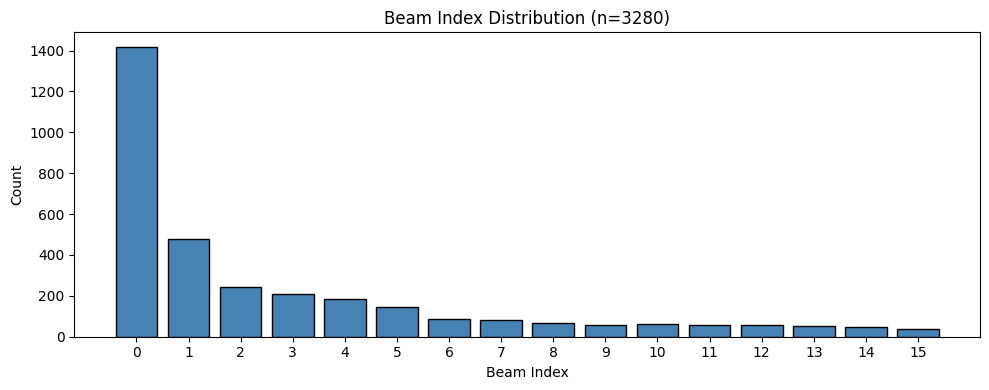

Saved: /Users/sadmanrahin/Documents/multimodal_dataset/audit_output/beam_distribution.png

SNR ANALYSIS
Count:  3280
Min:    13.09 dB
Max:    61.25 dB
Mean:   49.62 dB
Median: 49.99 dB
Std:    4.91 dB
Range:  48.16 dB
  P05: 41.82 dB
  P10: 43.76 dB
  P25: 46.91 dB
  P50: 49.99 dB
  P75: 53.04 dB
  P90: 55.24 dB
  P95: 56.40 dB

Outliers (|z| > 3): 13 (0.4%)


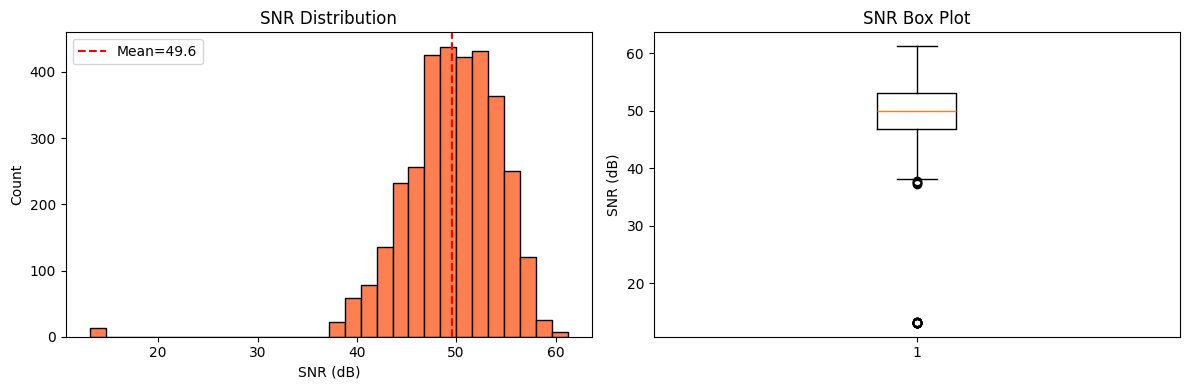

Saved: /Users/sadmanrahin/Documents/multimodal_dataset/audit_output/snr_distribution.png

LOS/NLOS ANALYSIS
  NLOS (class 0):  2718 (82.9%)
  LOS (class 1):   562 (17.1%)
⚠️  Moderate imbalance. May want class weights.
Baseline accuracy (majority class): 82.9%


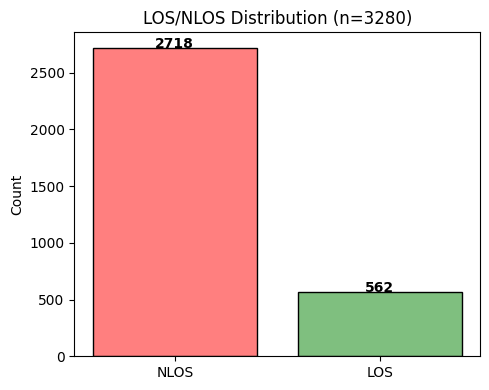

Saved: /Users/sadmanrahin/Documents/multimodal_dataset/audit_output/los_nlos_distribution.png

OUTAGE CLASS ANALYSIS
  Outage (class 0):   820 (25.0%)
  Degraded (class 1):   819 (25.0%)
  Good (class 2):  1641 (50.0%)
Baseline accuracy (majority class): 50.0%

SNR statistics per outage class:
  Outage: mean=43.4, std=4.4, range=[13.1, 46.9]
  Degraded: mean=48.5, std=0.9, range=[46.9, 50.0]
  Good: mean=53.3, std=2.2, range=[50.0, 61.3]


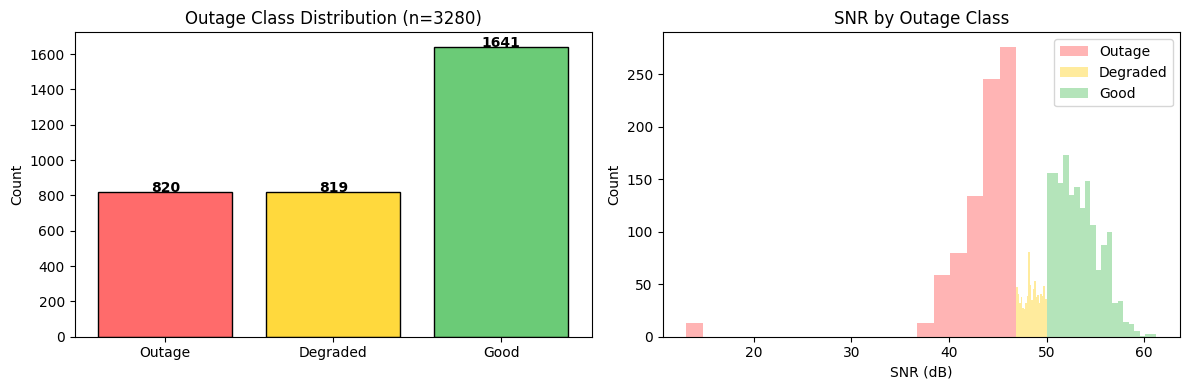

Saved: /Users/sadmanrahin/Documents/multimodal_dataset/audit_output/outage_distribution.png

CROSS-TASK CORRELATIONS

SNR per beam index:
  Beam  0: n=1418, SNR mean=49.6 ± 4.8
  Beam  1: n=478, SNR mean=49.8 ± 4.7
  Beam  2: n=244, SNR mean=49.8 ± 4.4
  Beam  3: n=207, SNR mean=49.5 ± 5.3
  Beam  4: n=184, SNR mean=49.9 ± 5.1
  Beam  5: n=144, SNR mean=50.7 ± 5.0
  Beam  6: n= 86, SNR mean=49.2 ± 4.1
  Beam  7: n= 84, SNR mean=49.3 ± 4.0
  Beam  8: n= 65, SNR mean=48.7 ± 4.3
  Beam  9: n= 56, SNR mean=49.4 ± 4.5
  Beam 10: n= 61, SNR mean=50.9 ± 4.0
  Beam 11: n= 59, SNR mean=48.1 ± 7.7
  Beam 12: n= 56, SNR mean=48.5 ± 6.4
  Beam 13: n= 53, SNR mean=48.6 ± 4.2
  Beam 14: n= 48, SNR mean=49.6 ± 6.7
  Beam 15: n= 37, SNR mean=49.3 ± 4.2

Beam distribution per LOS/NLOS:
  NLOS: n=2718, top beams: [(0, 1181), (1, 402), (2, 189)]
  LOS: n=562, top beams: [(0, 237), (1, 76), (2, 55)]

SNR per LOS/NLOS:
  NLOS: mean=49.8, std=4.1
  LOS: mean=49.0, std=7.7


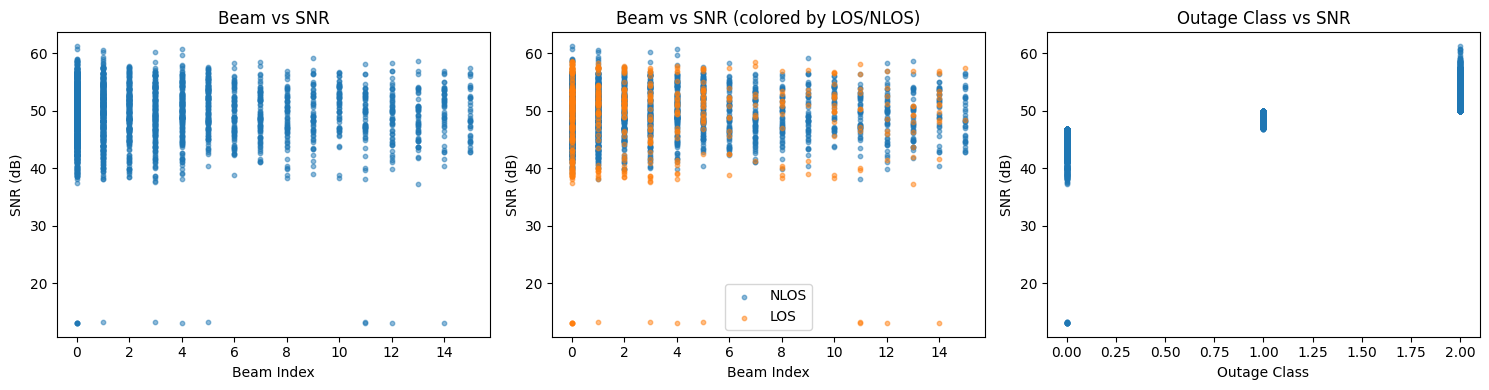

Saved: /Users/sadmanrahin/Documents/multimodal_dataset/audit_output/cross_task_correlations.png

FEATURE SANITY CHECK (first 5 samples)

--- Sample 0 ---
  tensor: shape=(16, 16, 6, 2), dtype=float32, range=[-0.0001, 0.0001], mean=-0.0000, NaN=0, Inf=0

--- Sample 1 ---
  tensor: shape=(16, 16, 6, 2), dtype=float32, range=[-0.0001, 0.0001], mean=0.0000, NaN=0, Inf=0

--- Sample 2 ---
  tensor: shape=(16, 16, 6, 2), dtype=float32, range=[-0.0001, 0.0001], mean=0.0000, NaN=0, Inf=0

--- Sample 3 ---
  tensor: shape=(16, 16, 6, 2), dtype=float32, range=[-0.0001, 0.0001], mean=-0.0000, NaN=0, Inf=0

--- Sample 4 ---
  tensor: shape=(16, 16, 6, 2), dtype=float32, range=[-0.0001, 0.0001], mean=0.0000, NaN=0, Inf=0

LABEL ALIGNMENT / CONSISTENCY CHECK
  ✅ All 10 samples consistent across repeated access.

TRAINABILITY ESTIMATE

Beam (16-class classification):
  Occupied classes: 16
  Min samples in a class: 37
  Recommendation: ≥20 samples/class → need ≥320 total

SNR (regression):
  Samples:

In [36]:
"""
Data Audit Script
=================
Run this to understand your dataset before training.
Covers: label distributions, class imbalance, feature sanity, alignment checks.
"""

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from collections import Counter

# ── 1. Adjust this import to match your actual dataset class ──
# If your dataset is defined in a notebook, copy the class here or
# import from your module:
# from your_module import MultimodalDataset, CFG

# ── CONFIGURATION ──────────────────────────────────────────────
# Update these paths / params to match your setup
DATA_DIR = "/Users/sadmanrahin/Documents/multimodal_dataset"
OUTPUT_DIR = os.path.join(DATA_DIR, "audit_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_BEAM_CLASSES = 16
NUM_OUTAGE_CLASSES = 3


def load_dataset():
    """
    Load your dataset. Adapt this to however you instantiate it.
    Must return an object where ds[i] -> (features, labels_dict)
    """
    # ── Option A: import from your module ──
    # from your_module import MultimodalDataset, CFG
    # ds = MultimodalDataset(CFG)
    # return ds

    # ── Option B: run from notebook ──
    # If running inside notebook, 'ds' should already be in scope.
    # Comment out this function and use ds directly.

    raise NotImplementedError(
        "Edit load_dataset() to return your dataset object. "
        "Or paste this script into your notebook where 'ds' is already defined."
    )


def collect_all_labels(ds):
    """Single pass over dataset to collect all labels and sample features."""
    print(f"Dataset size: {len(ds)} samples\n")

    all_beam = []
    all_snr = []
    all_los_nlos = []
    all_outage = []
    sample_features = []  # store first few for inspection

    for i in range(len(ds)):
        features, labels = ds[i]

        all_beam.append(int(labels['beam_index']))
        all_snr.append(float(labels['snr']))
        all_los_nlos.append(int(labels['los_nlos']))
        all_outage.append(int(labels['outage_class']))

        if i < 5:
            sample_features.append(features)

    return {
        'beam': np.array(all_beam),
        'snr': np.array(all_snr),
        'los_nlos': np.array(all_los_nlos),
        'outage': np.array(all_outage),
        'sample_features': sample_features,
    }


# ═══════════════════════════════════════════════════════════════
# AUDIT CHECKS
# ═══════════════════════════════════════════════════════════════

def audit_beam(beam_labels):
    """Beam index distribution and imbalance analysis."""
    print("=" * 60)
    print("BEAM INDEX ANALYSIS")
    print("=" * 60)

    counts = np.bincount(beam_labels, minlength=NUM_BEAM_CLASSES)
    total = len(beam_labels)

    print(f"Total samples: {total}")
    print(f"Num classes with >0 samples: {np.sum(counts > 0)} / {NUM_BEAM_CLASSES}")
    print(f"Num classes with 0 samples:  {np.sum(counts == 0)}")
    print()

    # Per-class breakdown
    print(f"{'Class':>6} {'Count':>6} {'Pct':>7} {'Bar'}")
    print("-" * 50)
    for i in range(NUM_BEAM_CLASSES):
        pct = counts[i] / total * 100 if total > 0 else 0
        bar = "█" * int(pct)
        print(f"{i:>6} {counts[i]:>6} {pct:>6.1f}% {bar}")

    # Imbalance metrics
    occupied = counts[counts > 0]
    if len(occupied) > 1:
        imbalance_ratio = occupied.max() / occupied.min()
        print(f"\nImbalance ratio (max/min among occupied): {imbalance_ratio:.1f}x")
    else:
        print(f"\nWARNING: Only {len(occupied)} class(es) occupied — classification is trivial!")

    majority_class = np.argmax(counts)
    majority_pct = counts[majority_class] / total * 100
    print(f"Majority class: {majority_class} ({majority_pct:.1f}% of data)")
    print(f"Baseline accuracy (always predict majority): {majority_pct:.1f}%")

    if majority_pct > 90:
        print("  SEVERE IMBALANCE: >90% in one class. Model will likely collapse to majority.")
    elif majority_pct > 60:
        print("  MODERATE IMBALANCE: Consider oversampling or focal loss.")

    # Effective number of classes
    probs = counts / total
    probs = probs[probs > 0]
    entropy = -np.sum(probs * np.log2(probs))
    effective_classes = 2 ** entropy
    print(f"Entropy: {entropy:.2f} bits (uniform 16-class = {np.log2(16):.2f} bits)")
    print(f"Effective number of classes: {effective_classes:.1f}")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(range(NUM_BEAM_CLASSES), counts, color='steelblue', edgecolor='black')
    ax.set_xlabel("Beam Index")
    ax.set_ylabel("Count")
    ax.set_title(f"Beam Index Distribution (n={total})")
    ax.set_xticks(range(NUM_BEAM_CLASSES))
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "beam_distribution.png"), dpi=150)
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/beam_distribution.png\n")

    return counts


def audit_snr(snr_labels):
    """SNR distribution analysis."""
    print("=" * 60)
    print("SNR ANALYSIS")
    print("=" * 60)

    print(f"Count:  {len(snr_labels)}")
    print(f"Min:    {snr_labels.min():.2f} dB")
    print(f"Max:    {snr_labels.max():.2f} dB")
    print(f"Mean:   {snr_labels.mean():.2f} dB")
    print(f"Median: {np.median(snr_labels):.2f} dB")
    print(f"Std:    {snr_labels.std():.2f} dB")
    print(f"Range:  {snr_labels.max() - snr_labels.min():.2f} dB")

    # Percentiles
    for p in [5, 10, 25, 50, 75, 90, 95]:
        val = np.percentile(snr_labels, p)
        print(f"  P{p:02d}: {val:.2f} dB")

    # Check for constant or near-constant
    if snr_labels.std() < 0.01:
        print(" SNR is nearly constant — regression target has no variance!")

    # Check for outliers (beyond 3 std)
    z_scores = np.abs((snr_labels - snr_labels.mean()) / (snr_labels.std() + 1e-9))
    n_outliers = np.sum(z_scores > 3)
    print(f"\nOutliers (|z| > 3): {n_outliers} ({n_outliers/len(snr_labels)*100:.1f}%)")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(snr_labels, bins=30, color='coral', edgecolor='black')
    axes[0].set_xlabel("SNR (dB)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("SNR Distribution")
    axes[0].axvline(snr_labels.mean(), color='red', linestyle='--', label=f'Mean={snr_labels.mean():.1f}')
    axes[0].legend()

    axes[1].boxplot(snr_labels, vert=True)
    axes[1].set_ylabel("SNR (dB)")
    axes[1].set_title("SNR Box Plot")

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "snr_distribution.png"), dpi=150)
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/snr_distribution.png\n")


def audit_los_nlos(los_nlos_labels):
    """LOS/NLOS binary classification analysis."""
    print("=" * 60)
    print("LOS/NLOS ANALYSIS")
    print("=" * 60)

    counts = np.bincount(los_nlos_labels, minlength=2)
    total = len(los_nlos_labels)

    labels_map = {0: "NLOS", 1: "LOS"}
    for i in range(2):
        pct = counts[i] / total * 100
        name = labels_map.get(i, f"Class {i}")
        print(f"  {name} (class {i}): {counts[i]:>5} ({pct:.1f}%)")

    if counts.min() == 0:
        print("  ONE CLASS IS COMPLETELY ABSENT — model will trivially predict 100% accuracy!")
        print("    This task provides zero learning signal.")
    elif counts.min() / total < 0.1:
        print("  Severe imbalance (<10% minority). Consider dropping this task or oversampling.")
    elif counts.min() / total < 0.3:
        print("  Moderate imbalance. May want class weights.")

    majority_pct = counts.max() / total * 100
    print(f"Baseline accuracy (majority class): {majority_pct:.1f}%")

    # If all samples are one class -> 100% accuracy is meaningless
    if counts.min() == 0:
        print(" Your model showing 100% LOS/NLOS accuracy is TRIVIAL — all labels are the same class.")

    # Plot
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar([labels_map.get(i, f"Class {i}") for i in range(2)], counts,
           color=['#ff7f7f', '#7fbf7f'], edgecolor='black')
    ax.set_ylabel("Count")
    ax.set_title(f"LOS/NLOS Distribution (n={total})")
    for i, c in enumerate(counts):
        ax.text(i, c + 0.5, str(c), ha='center', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "los_nlos_distribution.png"), dpi=150)
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/los_nlos_distribution.png\n")

    return counts


def audit_outage(outage_labels, snr_labels):
    """Outage class analysis with SNR overlay."""
    print("=" * 60)
    print("OUTAGE CLASS ANALYSIS")
    print("=" * 60)

    counts = np.bincount(outage_labels, minlength=NUM_OUTAGE_CLASSES)
    total = len(outage_labels)

    labels_map = {0: "Outage", 1: "Degraded", 2: "Good"}
    for i in range(NUM_OUTAGE_CLASSES):
        pct = counts[i] / total * 100
        name = labels_map.get(i, f"Class {i}")
        print(f"  {name} (class {i}): {counts[i]:>5} ({pct:.1f}%)")

    if counts.min() == 0:
        print("  AT LEAST ONE OUTAGE CLASS IS EMPTY — degenerate classification!")

    majority_pct = counts.max() / total * 100
    print(f"Baseline accuracy (majority class): {majority_pct:.1f}%")

    # SNR per outage class
    print("\nSNR statistics per outage class:")
    for i in range(NUM_OUTAGE_CLASSES):
        mask = outage_labels == i
        if mask.sum() > 0:
            s = snr_labels[mask]
            name = labels_map.get(i, f"Class {i}")
            print(f"  {name}: mean={s.mean():.1f}, std={s.std():.1f}, "
                  f"range=[{s.min():.1f}, {s.max():.1f}]")
        else:
            print(f"  {labels_map.get(i, f'Class {i}')}: NO SAMPLES")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    colors = ['#ff6b6b', '#ffd93d', '#6bcb77']
    axes[0].bar([labels_map.get(i, f"C{i}") for i in range(NUM_OUTAGE_CLASSES)],
                counts, color=colors, edgecolor='black')
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"Outage Class Distribution (n={total})")
    for i, c in enumerate(counts):
        axes[0].text(i, c + 0.5, str(c), ha='center', fontweight='bold')

    # SNR histogram colored by outage class
    for i in range(NUM_OUTAGE_CLASSES):
        mask = outage_labels == i
        if mask.sum() > 0:
            axes[1].hist(snr_labels[mask], bins=20, alpha=0.5,
                         label=labels_map.get(i, f"C{i}"), color=colors[i])
    axes[1].set_xlabel("SNR (dB)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("SNR by Outage Class")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "outage_distribution.png"), dpi=150)
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/outage_distribution.png\n")

    return counts


def audit_cross_task_correlations(data):
    """Check relationships between tasks."""
    print("=" * 60)
    print("CROSS-TASK CORRELATIONS")
    print("=" * 60)

    beam = data['beam']
    snr = data['snr']
    los = data['los_nlos']
    outage = data['outage']

    # SNR vs Beam (does beam choice correlate with SNR?)
    print("\nSNR per beam index:")
    for b in range(NUM_BEAM_CLASSES):
        mask = beam == b
        if mask.sum() > 0:
            s = snr[mask]
            print(f"  Beam {b:2d}: n={mask.sum():3d}, SNR mean={s.mean():.1f} ± {s.std():.1f}")

    # LOS vs Beam
    print("\nBeam distribution per LOS/NLOS:")
    for l in range(2):
        mask = los == l
        if mask.sum() > 0:
            bc = np.bincount(beam[mask], minlength=NUM_BEAM_CLASSES)
            top3 = np.argsort(bc)[-3:][::-1]
            name = "LOS" if l == 1 else "NLOS"
            print(f"  {name}: n={mask.sum()}, top beams: "
                  f"{[(int(t), int(bc[t])) for t in top3]}")

    # LOS vs SNR
    print("\nSNR per LOS/NLOS:")
    for l in range(2):
        mask = los == l
        if mask.sum() > 0:
            s = snr[mask]
            name = "LOS" if l == 1 else "NLOS"
            print(f"  {name}: mean={s.mean():.1f}, std={s.std():.1f}")

    # Correlation plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].scatter(beam, snr, alpha=0.5, s=10)
    axes[0].set_xlabel("Beam Index")
    axes[0].set_ylabel("SNR (dB)")
    axes[0].set_title("Beam vs SNR")

    for l in range(2):
        mask = los == l
        name = "LOS" if l == 1 else "NLOS"
        if mask.sum() > 0:
            axes[1].scatter(beam[mask], snr[mask], alpha=0.5, s=10, label=name)
    axes[1].set_xlabel("Beam Index")
    axes[1].set_ylabel("SNR (dB)")
    axes[1].set_title("Beam vs SNR (colored by LOS/NLOS)")
    axes[1].legend()

    axes[2].scatter(outage, snr, alpha=0.5, s=10)
    axes[2].set_xlabel("Outage Class")
    axes[2].set_ylabel("SNR (dB)")
    axes[2].set_title("Outage Class vs SNR")

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "cross_task_correlations.png"), dpi=150)
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/cross_task_correlations.png\n")


def audit_features(sample_features):
    """Inspect feature shapes, ranges, and NaN/Inf checks."""
    print("=" * 60)
    print("FEATURE SANITY CHECK (first 5 samples)")
    print("=" * 60)

    for i, feat in enumerate(sample_features):
        print(f"\n--- Sample {i} ---")
        if isinstance(feat, dict):
            for key, val in feat.items():
                if hasattr(val, 'shape'):
                    arr = np.array(val) if not isinstance(val, np.ndarray) else val
                    print(f"  {key:>20s}: shape={arr.shape}, dtype={arr.dtype}, "
                          f"range=[{arr.min():.4f}, {arr.max():.4f}], "
                          f"mean={arr.mean():.4f}, "
                          f"NaN={np.isnan(arr).sum()}, Inf={np.isinf(arr).sum()}")
                else:
                    print(f"  {key:>20s}: type={type(val).__name__}, value={val}")
        elif hasattr(feat, 'shape'):
            arr = np.array(feat) if not isinstance(feat, np.ndarray) else feat
            print(f"  tensor: shape={arr.shape}, dtype={arr.dtype}, "
                  f"range=[{arr.min():.4f}, {arr.max():.4f}], "
                  f"mean={arr.mean():.4f}, "
                  f"NaN={np.isnan(arr).sum()}, Inf={np.isinf(arr).sum()}")
        elif isinstance(feat, (list, tuple)):
            print(f"  type={type(feat).__name__}, len={len(feat)}")
            for j, sub in enumerate(feat):
                if hasattr(sub, 'shape'):
                    arr = np.array(sub) if not isinstance(sub, np.ndarray) else sub
                    print(f"    [{j}]: shape={arr.shape}, range=[{arr.min():.4f}, {arr.max():.4f}], "
                          f"NaN={np.isnan(arr).sum()}")
        else:
            print(f"  type={type(feat).__name__}")
    print()


def audit_label_alignment(ds, n_check=10):
    """Spot-check that labels are consistent across repeated access."""
    print("=" * 60)
    print("LABEL ALIGNMENT / CONSISTENCY CHECK")
    print("=" * 60)

    n_check = min(n_check, len(ds))
    mismatches = 0

    for i in range(n_check):
        _, labels1 = ds[i]
        _, labels2 = ds[i]

        for key in labels1:
            v1 = float(labels1[key])
            v2 = float(labels2[key])
            if abs(v1 - v2) > 1e-6:
                print(f"  Sample {i}, key '{key}': {v1} != {v2}")
                mismatches += 1

    if mismatches == 0:
        print(f" All {n_check} samples consistent across repeated access.")
    else:
        print(f" {mismatches} mismatches found — possible randomness in data loading!")
    print()


def audit_trainability_estimate(data):
    """Rough estimate: is there enough data to learn each task?"""
    print("=" * 60)
    print("TRAINABILITY ESTIMATE")
    print("=" * 60)

    n = len(data['beam'])

    # Beam: rule of thumb — at least 10-20 samples per class
    beam_counts = np.bincount(data['beam'], minlength=NUM_BEAM_CLASSES)
    occupied = np.sum(beam_counts > 0)
    min_per_class = beam_counts[beam_counts > 0].min()
    print(f"\nBeam ({NUM_BEAM_CLASSES}-class classification):")
    print(f"  Occupied classes: {occupied}")
    print(f"  Min samples in a class: {min_per_class}")
    print(f"  Recommendation: ≥20 samples/class → need ≥{occupied * 20} total")
    if min_per_class < 5:
        print(f"  Classes with <5 samples will be nearly impossible to learn.")
    if n < occupied * 20:
        print(f"  Dataset likely too small for {occupied}-class beam prediction.")

    # SNR regression
    print(f"\nSNR (regression):")
    print(f"  Samples: {n}")
    print(f"  Variance: {data['snr'].std():.2f}")
    if n < 50:
        print(f"  <50 samples for regression is very challenging.")

    # LOS/NLOS
    los_counts = np.bincount(data['los_nlos'], minlength=2)
    print(f"\nLOS/NLOS (binary classification):")
    print(f"  Class 0: {los_counts[0]}, Class 1: {los_counts[1]}")
    if los_counts.min() == 0:
        print(f" TRIVIAL — only one class present. Drop this task.")
    elif los_counts.min() < 5:
        print(f"  Minority class has <5 samples.")

    # Outage
    out_counts = np.bincount(data['outage'], minlength=NUM_OUTAGE_CLASSES)
    print(f"\nOutage ({NUM_OUTAGE_CLASSES}-class classification):")
    for i in range(NUM_OUTAGE_CLASSES):
        print(f"  Class {i}: {out_counts[i]}")
    if out_counts.min() == 0:
        print(f"  At least one class empty.")

    # Overall
    print(f"\n{'='*40}")
    print(f"OVERALL: {n} samples, 4 tasks")
    if n < 100:
        print(f"  With {n} samples, multi-task learning is extremely difficult.")
        print(f"   Recommendations:")
        print(f"   1. Reduce to 1-2 tasks max")
        print(f"   2. Use much simpler model (linear heads, frozen backbone)")
        print(f"   3. Get more data")
        print(f"   4. Use heavy augmentation")
    print()


def generate_summary(data):
    """Print a one-page summary."""
    print("\n" + "═" * 60)
    print("SUMMARY REPORT")
    print("═" * 60)

    n = len(data['beam'])
    beam_counts = np.bincount(data['beam'], minlength=NUM_BEAM_CLASSES)
    los_counts = np.bincount(data['los_nlos'], minlength=2)
    out_counts = np.bincount(data['outage'], minlength=NUM_OUTAGE_CLASSES)

    print(f"Dataset size:           {n}")
    print(f"Beam classes occupied:  {np.sum(beam_counts > 0)}/{NUM_BEAM_CLASSES}")
    print(f"Beam majority class:    {np.argmax(beam_counts)} ({beam_counts.max()}/{n} = {beam_counts.max()/n*100:.0f}%)")
    print(f"LOS/NLOS split:         {los_counts[0]}/{los_counts[1]}")
    print(f"Outage split:           {out_counts[0]}/{out_counts[1]}/{out_counts[2]}")
    print(f"SNR range:              [{data['snr'].min():.1f}, {data['snr'].max():.1f}] dB")
    print(f"SNR std:                {data['snr'].std():.2f} dB")

    issues = []
    if n < 100:
        issues.append(f"Only {n} samples — insufficient for multi-task learning")
    if beam_counts.max() / n > 0.5:
        issues.append(f"Beam class {np.argmax(beam_counts)} has >{50}% of data")
    if np.sum(beam_counts > 0) < 4:
        issues.append(f"Only {np.sum(beam_counts > 0)} beam classes occupied")
    if los_counts.min() == 0:
        issues.append("LOS/NLOS has only one class — trivial task")
    if out_counts.min() == 0:
        issues.append("Outage has empty class(es)")
    if data['snr'].std() < 1.0:
        issues.append("SNR has very low variance")

    if issues:
        print(f"\n Issues Found ({len(issues)}):")
        for i, issue in enumerate(issues, 1):
            print(f"  {i}. {issue}")
    else:
        print("\n No major issues found.")

    print()


# ═══════════════════════════════════════════════════════════════
# MAIN
# ═══════════════════════════════════════════════════════════════

def run_audit(ds):
    """Run all audits. Pass your dataset object."""
    data = collect_all_labels(ds)

    audit_beam(data['beam'])
    audit_snr(data['snr'])
    audit_los_nlos(data['los_nlos'])
    audit_outage(data['outage'], data['snr'])
    audit_cross_task_correlations(data)
    audit_features(data['sample_features'])
    audit_label_alignment(ds)
    audit_trainability_estimate(data)
    generate_summary(data)

    print(f"All plots saved to: {OUTPUT_DIR}/")
    return data


if __name__ == "__main__":
    run_audit(ds)

In [37]:
# After loading clients, before training
print("\n=== Train/Test Split Verification ===")
for i in range(3):  # Check first 3 clients
    print(f"\nClient {i} (trajectory: {clients[i].trajectory_id}):")
    print(f"  Train indices: {clients[i].train_indices[:5]}... (total: {len(clients[i].train_indices)})")
    print(f"  Test indices: {clients[i].test_indices[:5]}... (total: {len(clients[i].test_indices)})")
    
    # Check for overlap
    overlap = set(clients[i].train_indices) & set(clients[i].test_indices)
    print(f"  Overlap: {len(overlap)} samples")
    
    # Check if indices are actually different
    if len(clients[i].test_indices) > 0:
        _, labels_0 = ds[clients[i].test_indices[0]]
        _, labels_last = ds[clients[i].test_indices[-1]]
        print(f"  First test beam: {labels_0['beam_index']}, Last test beam: {labels_last['beam_index']}")

# Check if test accuracies are per-client or aggregated
print("\n=== Accuracy Analysis ===")
for metric_name in ['beam_accuracy', 'los_nlos_accuracy', 'outage_accuracy']:
    if metric_name in history.metrics_distributed:
        print(f"\n{metric_name}:")
        for round_num, value in history.metrics_distributed[metric_name]:
            print(f"  Round {round_num}: {value:.6f}")


=== Train/Test Split Verification ===

Client 0 (trajectory: Town03_Town03_5wayroad_cav_1):
  Train indices: [0, 1, 2, 3, 4]... (total: 77)
  Test indices: [77, 78, 79, 80, 81]... (total: 33)
  Overlap: 0 samples
  First test beam: 0, Last test beam: 11

Client 1 (trajectory: Town03_Town03_5wayroad_cav_2):
  Train indices: [110, 111, 112, 113, 114]... (total: 77)
  Test indices: [187, 188, 189, 190, 191]... (total: 33)
  Overlap: 0 samples
  First test beam: 0, Last test beam: 4

Client 2 (trajectory: Town03_Town03_5wayroad_cav_3):
  Train indices: [220, 221, 222, 223, 224]... (total: 77)
  Test indices: [297, 298, 299, 300, 301]... (total: 33)
  Overlap: 0 samples
  First test beam: 7, Last test beam: 2

=== Accuracy Analysis ===

beam_accuracy:
  Round 1: 0.030303
  Round 2: 0.030303
  Round 3: 0.030303
  Round 4: 0.030303
  Round 5: 0.030303
  Round 6: 0.030303
  Round 7: 0.030303
  Round 8: 0.030303
  Round 9: 0.030303
  Round 10: 0.030303

los_nlos_accuracy:
  Round 1: 1.000000
 

In [ ]:
import json
import pickle
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. Results Saving Functions (FIXED for trajectory-based clients)
# ============================================================

def save_fl_results(history, clients, config, save_dir="c:/Users/sadma/Documents/multi_modal/results"):
    """
    Save Flower training history, client info, and config for later analysis.
    """
    save_dir = Path(save_dir)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    exp_dir = save_dir / f"exp_{timestamp}"
    exp_dir.mkdir(parents=True, exist_ok=True)
    
    print(f" Saving results to: {exp_dir}")
    
    def convert_metrics(metrics_dict):
        """Convert metrics dict where values are lists of (client_id, value) tuples"""
        result = {}
        for round_num, metric_list in metrics_dict.items():
            try:
                round_key = int(round_num)
            except (ValueError, TypeError):
                continue
            result[round_key] = {}
            for num_examples, client_metrics in metric_list:
                for key, value in client_metrics.items():
                    if key not in result[int(round_num)]:
                        result[int(round_num)][key] = []
                    result[int(round_num)][key].append(float(value))
        return result
    
    # 1. Save training history
    history_dict = {
        'losses_distributed': [(int(round), float(loss)) for round, loss in history.losses_distributed],
        'losses_centralized': [(int(round), float(loss)) for round, loss in history.losses_centralized] if history.losses_centralized else [],
        'metrics_distributed_fit': convert_metrics(history.metrics_distributed_fit) if history.metrics_distributed_fit else {},
        'metrics_distributed': convert_metrics(history.metrics_distributed) if history.metrics_distributed else {},
        'metrics_centralized': {
            k: [(int(round), float(val)) for round, val in vals]
            for k, vals in history.metrics_centralized.items()
        } if history.metrics_centralized else {},
    }
    
    with open(exp_dir / "history.json", 'w') as f:
        json.dump(history_dict, f, indent=2)
    print(f" Saved history.json")
    
    # 2. Save config
    config_serializable = {}
    for k, v in config.items():
        if isinstance(v, (int, float, str, bool, list, tuple)):
            config_serializable[k] = v
        elif isinstance(v, dict):
            config_serializable[k] = {
                str(k2): v2 for k2, v2 in v.items() 
                if isinstance(v2, (int, float, str, bool, list))
            }
    
    with open(exp_dir / "config.json", 'w') as f:
        json.dump(config_serializable, f, indent=2)
    print(f" Saved config.json")
    
    # 3. Save client statistics (FIXED: uses train_indices/test_indices)
    tasks = ["beam", "snr", "outage", "los_nlos"]
    client_stats = {
        'n_clients': len(clients),
        'tasks': tasks,
        'samples_per_client': {
            f'client_{i}': {
                'train': len(clients[i].train_indices),
                'test': len(clients[i].test_indices),
                'trajectory_id': clients[i].trajectory_id
            }
            for i in range(min(10, len(clients)))
        },
        'total_samples': {
            'train': int(sum(len(c.train_indices) for c in clients)),
            'test': int(sum(len(c.test_indices) for c in clients))
        } if clients else {},
    }
    
    with open(exp_dir / "client_stats.json", 'w') as f:
        json.dump(client_stats, f, indent=2)
    print(f" Saved client_stats.json")
    
    # 4. Save summary
    summary = {
        'timestamp': timestamp,
        'num_rounds': len(history.losses_distributed),
        'final_loss': float(history.losses_distributed[-1][1]) if history.losses_distributed else None,
        'n_clients': len(clients),
        'tasks': tasks,
    }
    
    with open(exp_dir / "summary.txt", 'w') as f:
        f.write("="*60 + "\n")
        f.write("FL Training Summary\n")
        f.write("="*60 + "\n")
        for k, v in summary.items():
            f.write(f"{k}: {v}\n")
    print(f" Saved summary.txt")
    
    print(f" Results saved to: {exp_dir}")
    return exp_dir


# 2. Results Loading Functions

def load_fl_results(results_dir):
    """Load saved FL results from directory."""
    results_dir = Path(results_dir)
    
    if not results_dir.exists():
        raise FileNotFoundError(f"Results directory not found: {results_dir}")
    
    results = {}
    
    with open(results_dir / "history.json", 'r') as f:
        results['history'] = json.load(f)
    with open(results_dir / "config.json", 'r') as f:
        results['config'] = json.load(f)
    with open(results_dir / "client_stats.json", 'r') as f:
        results['client_stats'] = json.load(f)
    with open(results_dir / "summary.txt", 'r') as f:
        results['summary_text'] = f.read()
    
    print(f"Loaded results from: {results_dir.name}")
    return results


def list_experiments(results_dir="c:/Users/sadma/Documents/multi_modal/results"):
    """List all saved experiments"""
    results_dir = Path(results_dir)
    if not results_dir.exists():
        print(f"No results directory found at {results_dir}")
        return []
    
    exps = sorted([d for d in results_dir.iterdir() if d.is_dir() and d.name.startswith('exp_')])
    
    print(f"\nFound {len(exps)} experiments:")
    print("="*60)
    for i, exp in enumerate(exps, 1):
        summary_file = exp / "summary.txt"
        if summary_file.exists():
            with open(summary_file, 'r') as f:
                lines = f.readlines()
                timestamp = exp.name.replace('exp_', '')
                print(f"{i}. {timestamp}")
                for line in lines:
                    if 'num_rounds' in line or 'final_loss' in line or 'n_clients' in line:
                        print(f"   {line.strip()}")
        print()
    
    return exps


# ============================================================
# 3. Plotting Functions
# ============================================================

def plot_fl_results(results, save_path=None):
    """Create comprehensive plots from FL results."""
    history = results['history']
    config = results['config']
    
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Training Loss
    ax1 = plt.subplot(2, 3, 1)
    if history['losses_distributed']:
        rounds, losses = zip(*history['losses_distributed'])
        ax1.plot(rounds, losses, 'b-o', linewidth=2, markersize=4, label='Distributed')
    if history['losses_centralized']:
        rounds, losses = zip(*history['losses_centralized'])
        ax1.plot(rounds, losses, 'r--s', linewidth=2, markersize=4, label='Centralized')
    ax1.set_xlabel('Round', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Task-specific losses (training)
    ax2 = plt.subplot(2, 3, 2)
    fit_metrics = history['metrics_distributed_fit']
    if fit_metrics:
        for task in ['beam', 'snr', 'outage', 'los_nlos']:
            task_loss_key = f'{task}_loss'
            rounds = []
            losses = []
            for round_num in sorted([int(r) for r in fit_metrics.keys()]):
                if task_loss_key in fit_metrics[str(round_num)]:
                    rounds.append(round_num)
                    losses.append(np.mean(fit_metrics[str(round_num)][task_loss_key]))
            if rounds:
                ax2.plot(rounds, losses, '-o', linewidth=2, markersize=4, label=task)
    ax2.set_xlabel('Round', fontsize=12)
    ax2.set_ylabel('Task Loss', fontsize=12)
    ax2.set_title('Task-Specific Training Losses', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Accuracies (for classification tasks)
    ax3 = plt.subplot(2, 3, 3)
    eval_metrics = history['metrics_distributed']
    if eval_metrics:
        for task in ['beam', 'outage', 'los_nlos']:
            acc_key = f'{task}_accuracy'
            rounds = []
            accs = []
            for round_num in sorted([int(r) for r in eval_metrics.keys()]):
                if acc_key in eval_metrics[str(round_num)]:
                    rounds.append(round_num)
                    accs.append(np.mean(eval_metrics[str(round_num)][acc_key]) * 100)
            if rounds:
                ax3.plot(rounds, accs, '-o', linewidth=2, markersize=4, label=task)
    ax3.set_xlabel('Round', fontsize=12)
    ax3.set_ylabel('Accuracy (%)', fontsize=12)
    ax3.set_title('Classification Accuracies', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. SNR MSE
    ax4 = plt.subplot(2, 3, 4)
    if eval_metrics:
        rounds = []
        mses = []
        for round_num in sorted([int(r) for r in eval_metrics.keys()]):
            if 'snr_mse' in eval_metrics[str(round_num)]:
                rounds.append(round_num)
                mses.append(np.mean(eval_metrics[str(round_num)]['snr_mse']))
        if rounds:
            ax4.plot(rounds, mses, 'g-o', linewidth=2, markersize=4)
    ax4.set_xlabel('Round', fontsize=12)
    ax4.set_ylabel('MSE', fontsize=12)
    ax4.set_title('SNR Prediction Error (MSE)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Beam prediction diversity (NEW diagnostic)
    ax5 = plt.subplot(2, 3, 5)
    if eval_metrics:
        rounds = []
        diversities = []
        for round_num in sorted([int(r) for r in eval_metrics.keys()]):
            if 'beam_num_unique_preds' in eval_metrics[str(round_num)]:
                rounds.append(round_num)
                diversities.append(np.mean(eval_metrics[str(round_num)]['beam_num_unique_preds']))
        if rounds:
            ax5.plot(rounds, diversities, 'm-o', linewidth=2, markersize=4)
            ax5.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Collapsed (1 class)')
            ax5.axhline(y=16, color='g', linestyle='--', alpha=0.5, label='Max diversity (16)')
            ax5.legend()
    ax5.set_xlabel('Round', fontsize=12)
    ax5.set_ylabel('Avg Unique Predictions', fontsize=12)
    ax5.set_title('Beam Prediction Diversity', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 6. Final metrics table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    final_text = "Final Metrics (Last Round)\n" + "="*30 + "\n"
    if eval_metrics:
        last_round = str(max([int(r) for r in eval_metrics.keys()]))
        final_metrics = eval_metrics[last_round]
        
        for key in sorted(final_metrics.keys()):
            vals = final_metrics[key]
            avg_val = np.mean(vals)
            if 'accuracy' in key:
                final_text += f"{key}: {avg_val*100:.2f}%\n"
            elif 'loss' in key or 'mse' in key:
                final_text += f"{key}: {avg_val:.4f}\n"
            else:
                final_text += f"{key}: {avg_val:.4f}\n"
    
    final_text += "\n" + "="*30 + "\n"
    client_stats = results['client_stats']
    final_text += f"Clients: {client_stats.get('n_clients', 'N/A')}\n"
    final_text += f"Tasks: {', '.join(client_stats.get('tasks', []))}\n"
    final_text += f"Local epochs: {config.get('local_epochs', 'N/A')}\n"
    final_text += f"Learning rate: {config.get('lr', 'N/A')}\n"
    final_text += f"Beam weight: {config.get('loss_weights', {}).get('beam', 'N/A')}\n"
    final_text += f"Focal gamma: {config.get('focal_gamma', 'N/A')}\n"
    
    ax6.text(0.1, 0.9, final_text, fontsize=10, family='monospace', 
             verticalalignment='top', transform=ax6.transAxes)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f" Saved plot to: {save_path}")
    
    plt.show()

In [ ]:
# Save results
results_dir = save_fl_results(
    history=history,
    clients=clients,
    config=CFG
)

# Load and plot immediately
results = load_fl_results(results_dir)
plot_fl_results(results, save_path=results_dir / "plots.png")

In [ ]:
# List all experiments
exps = list_experiments()

# Load the most recent
results = load_fl_results(exps[-1])

# Or load by specific timestamp
results = load_fl_results("c:/Users/sadma/Documents/multi_modal/results/exp_20260207_143022")

C:\Users\sadma\AppData\Local\Temp\ipykernel_24608\1199725660.py:241: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
C:\Users\sadma\AppData\Local\Temp\ipykernel_24608\1199725660.py:261: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


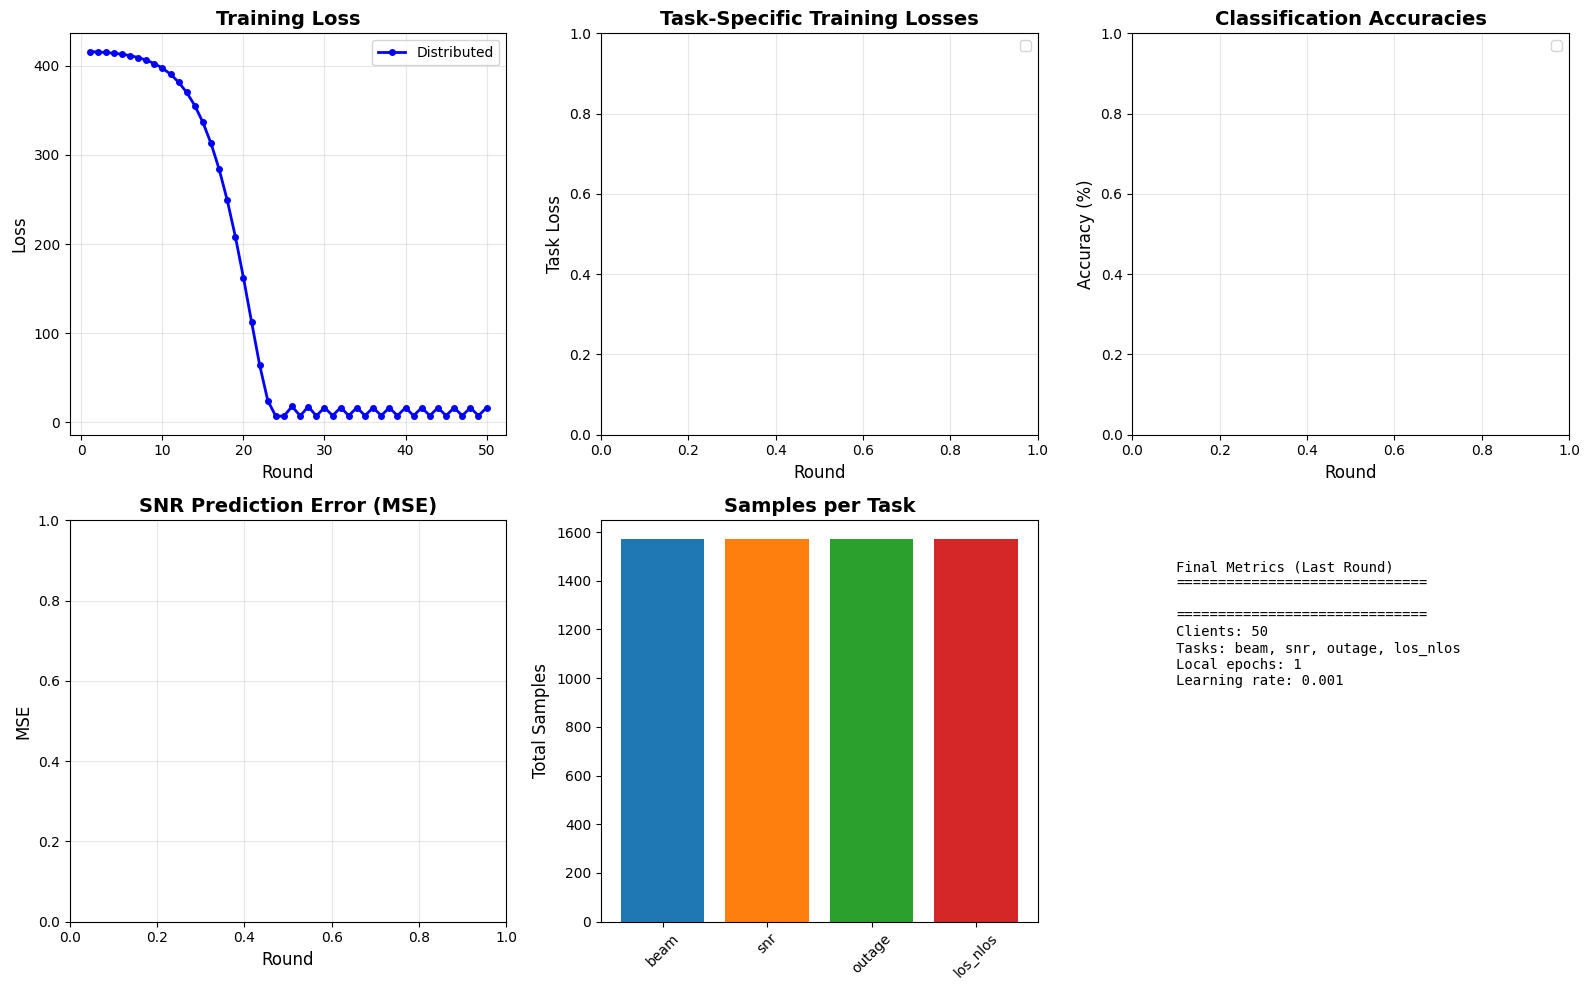

✓ Saved plot to: my_results.png


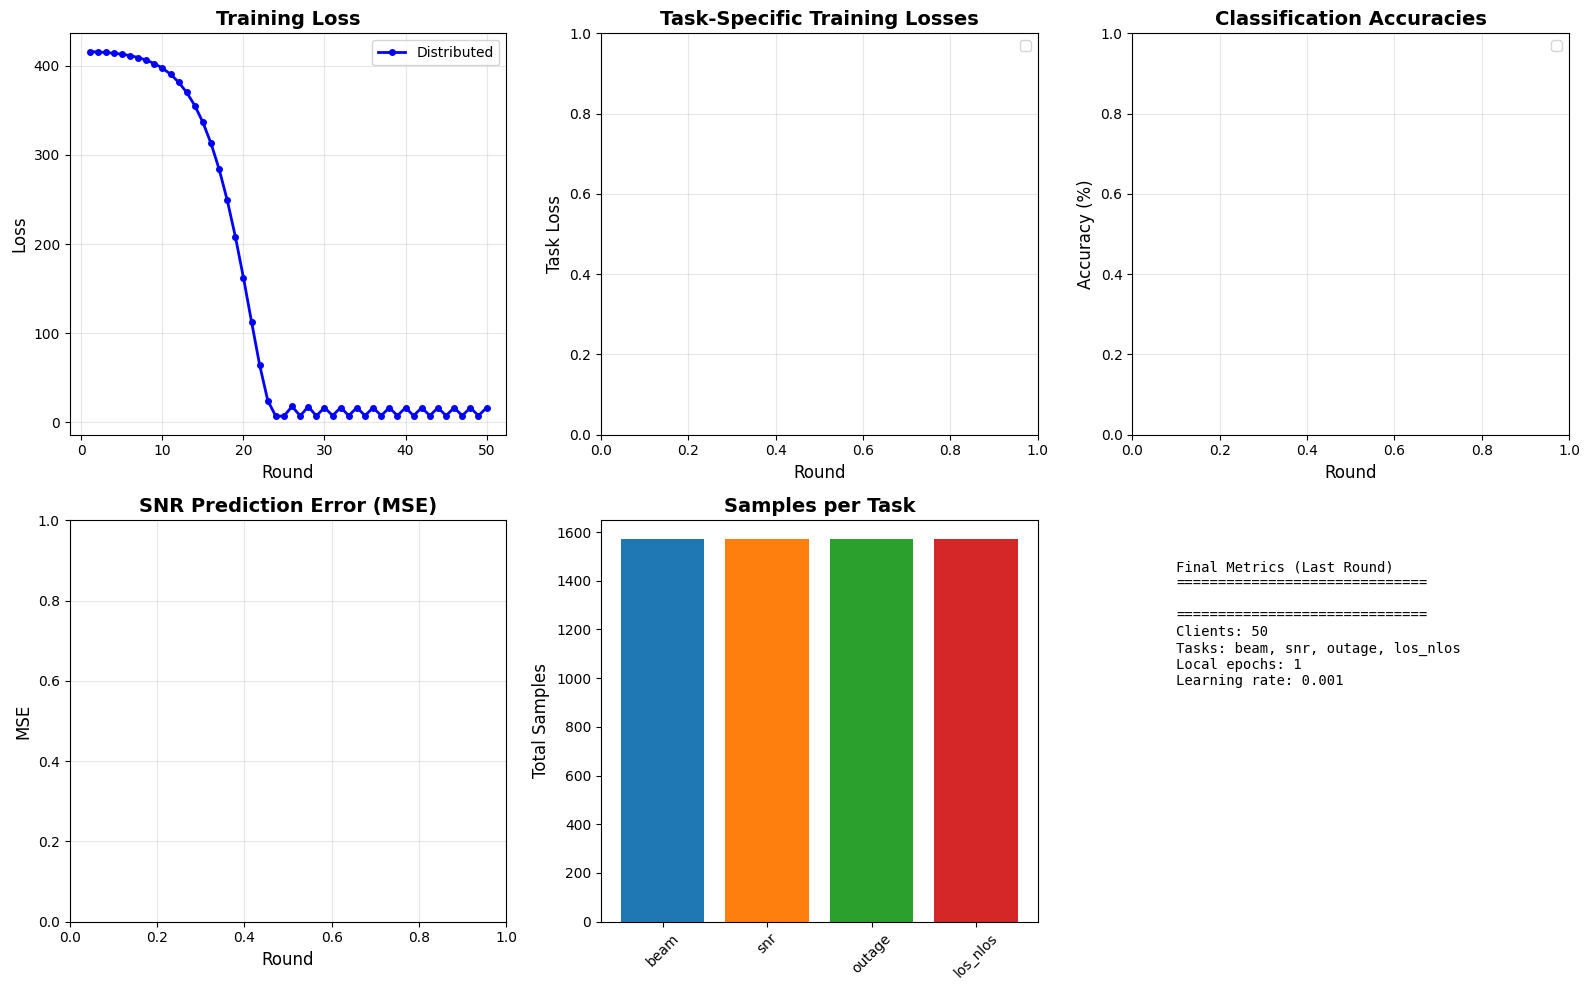

In [43]:
# Plot and display
plot_fl_results(results)

# Plot and save to file
plot_fl_results(results, save_path="my_results.png")

In [3]:
import numpy as np

data = np.load("326234_paths.npz")

print(data.files)


['a', 'tau', 'theta_t', 'phi_t', 'theta_r', 'phi_r', 'glob_phi_t', 'glob_phi_r', 'glob_theta_t', 'glob_theta_r']


In [27]:
print(len(ds))

3280
